# Understanding Hired Rides in NYC

_[Project prompt](https://docs.google.com/document/d/1VERPjEZcC1XSs4-02aM-DbkNr_yaJVbFjLJxaYQswqA/edit#)_

## Project Setup

In [1]:
# all import statements needed for the project

from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import pandas as pd
import requests
import sqlalchemy as db
import re
import geopandas as gpd
from shapely.geometry import Point
import math
import os
from pandas import DataFrame
from typing import List
from sqlalchemy import create_engine, text
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
from sqlalchemy import Column, Integer, String, Float, DateTime, Date
from sqlalchemy.schema import CreateTable
from sqlalchemy.ext.declarative import declarative_base
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
from IPython.display import display

## Part 1: Data Preprocessing

### Calculate Sample Size

### Common Functions

In [141]:
def get_all_urls_from_tlc_page(tlc_page_url: str) -> List[str]:
    """
    Extract all URLs from the NYC TLC webpage.

    Parameters:
        tlc_page_url (str): The URL of the NYC TLC webpage.

    Returns:
        list: A list of all stripped URLs found on the page.
    """
    
    response = requests.get(tlc_page_url)
    response.raise_for_status()  
    soup = BeautifulSoup(response.text, 'html.parser')
    urls = [link['href'].strip() for link in soup.find_all('a', href=True)]
    return urls

In [ ]:
def filter_taxi_and_hvfhv_urls(all_urls: List[str]) -> Tuple[List[str], List[str]]:
    """
    Filter URLs for Yellow Taxi and HVFHV Parquet files for the years 2020–2024.

    Parameters:
        all_urls (list): A list of URLs.

    Returns:
        tuple: (list of Yellow Taxi URLs, list of HVFHV URLs)
    """
    
    taxi_pattern = re.compile(r".*yellow_tripdata_20(20|21|22|23|24)-.*\.parquet$", re.IGNORECASE)
    hvfhv_pattern = re.compile(r".*fhvhv_tripdata_20(20|21|22|23|24)-.*\.parquet$", re.IGNORECASE)

    yellow_taxi_urls = [url for url in all_urls if taxi_pattern.search(url)]
    hvfhv_urls = [url for url in all_urls if hvfhv_pattern.search(url)]

    return yellow_taxi_urls, hvfhv_urls

### Download Taxi and HVFHV Data

In [150]:
def download_yellow_taxi_data(tlc_page_url: str, save_dir: str = "yellow_taxi_data") -> None:
    """
    Download all Yellow Taxi Parquet files for the years 2020–2024.

    Parameters:
        tlc_page_url (str): URL of the TLC page containing data links.
        save_dir (str): Directory to save Yellow Taxi data files.
    """

    all_urls = get_all_urls_from_tlc_page(tlc_page_url)
    base_url = "https://www1.nyc.gov"
    all_urls = convert_to_absolute_urls(all_urls, base_url)
    yellow_taxi_urls, _ = filter_taxi_and_hvfhv_urls(all_urls)

    print(f"Found {len(yellow_taxi_urls)} Yellow Taxi Parquet files.")

    # Download files
    os.makedirs(save_dir, exist_ok=True)
    for url in yellow_taxi_urls:
        download_parquet_file(url, save_dir)


In [151]:
tlc_page_url = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"

# Download Yellow Taxi data
download_yellow_taxi_data(tlc_page_url, save_dir="yellow_taxi_data")

Found 57 Yellow Taxi Parquet files.
Downloaded yellow_tripdata_2024-01.parquet to yellow_taxi_data/yellow_tripdata_2024-01.parquet
Downloaded yellow_tripdata_2024-02.parquet to yellow_taxi_data/yellow_tripdata_2024-02.parquet
Downloaded yellow_tripdata_2024-03.parquet to yellow_taxi_data/yellow_tripdata_2024-03.parquet
Downloaded yellow_tripdata_2024-04.parquet to yellow_taxi_data/yellow_tripdata_2024-04.parquet
Downloaded yellow_tripdata_2024-05.parquet to yellow_taxi_data/yellow_tripdata_2024-05.parquet
Downloaded yellow_tripdata_2024-06.parquet to yellow_taxi_data/yellow_tripdata_2024-06.parquet
Downloaded yellow_tripdata_2024-07.parquet to yellow_taxi_data/yellow_tripdata_2024-07.parquet
Downloaded yellow_tripdata_2024-08.parquet to yellow_taxi_data/yellow_tripdata_2024-08.parquet
Downloaded yellow_tripdata_2024-09.parquet to yellow_taxi_data/yellow_tripdata_2024-09.parquet
Downloaded yellow_tripdata_2023-01.parquet to yellow_taxi_data/yellow_tripdata_2023-01.parquet
Downloaded yel

In [153]:
def download_hvfhv_data(tlc_page_url: str, save_dir: str = "hvfhv_data") -> None:
    """
    Download all HVFHV Parquet files for the years 2020–2024.

    Parameters:
        tlc_page_url (str): URL of the TLC page containing data links.
        save_dir (str): Directory to save HVFHV data files.
    """
    
    all_urls = get_all_urls_from_tlc_page(tlc_page_url)
    base_url = "https://www1.nyc.gov"
    all_urls = convert_to_absolute_urls(all_urls, base_url)
    _, hvfhv_urls = filter_taxi_and_hvfhv_urls(all_urls)

    print(f"Found {len(hvfhv_urls)} HVFHV Parquet files.")

    # Download files
    os.makedirs(save_dir, exist_ok=True)
    for url in hvfhv_urls:
        download_parquet_file(url, save_dir)


In [154]:
# TLC page URL
tlc_page_url = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"

# Download HVFHV data
download_hvfhv_data(tlc_page_url, save_dir="hvfhv_data")


Found 57 HVFHV Parquet files.
Downloaded fhvhv_tripdata_2024-01.parquet to hvfhv_data/fhvhv_tripdata_2024-01.parquet
Downloaded fhvhv_tripdata_2024-02.parquet to hvfhv_data/fhvhv_tripdata_2024-02.parquet
Downloaded fhvhv_tripdata_2024-03.parquet to hvfhv_data/fhvhv_tripdata_2024-03.parquet
Downloaded fhvhv_tripdata_2024-04.parquet to hvfhv_data/fhvhv_tripdata_2024-04.parquet
Downloaded fhvhv_tripdata_2024-05.parquet to hvfhv_data/fhvhv_tripdata_2024-05.parquet
Downloaded fhvhv_tripdata_2024-06.parquet to hvfhv_data/fhvhv_tripdata_2024-06.parquet
Downloaded fhvhv_tripdata_2024-07.parquet to hvfhv_data/fhvhv_tripdata_2024-07.parquet
Downloaded fhvhv_tripdata_2024-08.parquet to hvfhv_data/fhvhv_tripdata_2024-08.parquet
Downloaded fhvhv_tripdata_2024-09.parquet to hvfhv_data/fhvhv_tripdata_2024-09.parquet
Downloaded fhvhv_tripdata_2023-01.parquet to hvfhv_data/fhvhv_tripdata_2023-01.parquet
Downloaded fhvhv_tripdata_2023-02.parquet to hvfhv_data/fhvhv_tripdata_2023-02.parquet
Downloaded fh

## Sampleing Taxi Data

In [4]:


def cochran_sample_size(population, confidence_level=0.95, margin_of_error=0.05, proportion=0.5) -> int:
    """
    Calculate sample size using Cochran's formula with finite population correction.

    Parameters:
        population (int): Total population size (e.g., number of records for a month).
        confidence_level (float): Desired confidence level (e.g., 0.95 for 95%).
        margin_of_error (float): Desired margin of error (e.g., 0.05 for 5%).
        proportion (float): Estimated proportion of the population (default 0.5 for max variability).

    Returns:
        int: Sample size.
    """

    z_scores = {0.9: 1.645, 0.95: 1.96, 0.99: 2.576}
    z = z_scores[confidence_level]

    # Initial sample size calculation
    n0 = (z**2 * proportion * (1 - proportion)) / (margin_of_error**2)

    # Apply finite population correction
    if population > 0:
        n = n0 / (1 + (n0 - 1) / population)
    else:
        n = n0

    return math.ceil(n)


## Calculate sample size for taxi

In [155]:
input_dir = "yellow_taxi_data"
output_dir = "sampled_taxi_data"
os.makedirs(output_dir, exist_ok=True)  

# Sampling parameters
confidence_level = 0.99
margin_of_error = 0.05
proportion = 0.5

for file_name in os.listdir(input_dir):
    if file_name.endswith(".parquet"):
        file_path = os.path.join(input_dir, file_name)
        print(f"Processing file: {file_name}")
        monthly_data = pd.read_parquet(file_path)
        population_size = len(monthly_data)
        
        # Calculate the sample size for the month
        sample_size = cochran_sample_size(population_size, confidence_level, margin_of_error, proportion)
        print(f"Population size: {population_size}, Sample size: {sample_size}")
        
        sampled_data = monthly_data.sample(n=sample_size, random_state=42)
        output_file = os.path.join(output_dir, f"sampled_{file_name}")
        sampled_data.to_parquet(output_file)
        print(f"Saved sampled data to: {output_file}")



Processing file: yellow_tripdata_2023-06.parquet
Population size: 3307234, Sample size: 664
Saved sampled data to: sampled_taxi_data/sampled_yellow_tripdata_2023-06.parquet
Processing file: yellow_tripdata_2022-10.parquet
Population size: 3675411, Sample size: 664
Saved sampled data to: sampled_taxi_data/sampled_yellow_tripdata_2022-10.parquet
Processing file: yellow_tripdata_2020-03.parquet
Population size: 3007687, Sample size: 664
Saved sampled data to: sampled_taxi_data/sampled_yellow_tripdata_2020-03.parquet
Processing file: yellow_tripdata_2021-05.parquet
Population size: 2507109, Sample size: 664
Saved sampled data to: sampled_taxi_data/sampled_yellow_tripdata_2021-05.parquet
Processing file: yellow_tripdata_2022-09.parquet
Population size: 3183767, Sample size: 664
Saved sampled data to: sampled_taxi_data/sampled_yellow_tripdata_2022-09.parquet
Processing file: yellow_tripdata_2024-04.parquet
Population size: 3514289, Sample size: 664
Saved sampled data to: sampled_taxi_data/sa

## Set sample size = 664 for taxi 

In [171]:
fixed_sample_size = 664

input_dir = "yellow_taxi_data"
output_dir = "sampled_taxi_data"
for file_name in os.listdir(input_dir):
    if file_name.endswith(".parquet"):
        file_path = os.path.join(input_dir, file_name)
        print(f"Processing file: {file_name}")
        monthly_data = pd.read_parquet(file_path)
        sampled_data = monthly_data.sample(n=fixed_sample_size, random_state=42)
        output_file = os.path.join(output_dir, f"sampled_{file_name}")
        sampled_data.to_parquet(output_file)
        print(f"Saved sampled data to: {output_file}")

Processing file: yellow_tripdata_2023-06.parquet
Saved sampled data to: sampled_taxi_data/sampled_yellow_tripdata_2023-06.parquet
Processing file: yellow_tripdata_2022-10.parquet
Saved sampled data to: sampled_taxi_data/sampled_yellow_tripdata_2022-10.parquet
Processing file: yellow_tripdata_2020-03.parquet
Saved sampled data to: sampled_taxi_data/sampled_yellow_tripdata_2020-03.parquet
Processing file: yellow_tripdata_2021-05.parquet
Saved sampled data to: sampled_taxi_data/sampled_yellow_tripdata_2021-05.parquet
Processing file: yellow_tripdata_2022-09.parquet
Saved sampled data to: sampled_taxi_data/sampled_yellow_tripdata_2022-09.parquet
Processing file: yellow_tripdata_2024-04.parquet
Saved sampled data to: sampled_taxi_data/sampled_yellow_tripdata_2024-04.parquet
Processing file: yellow_tripdata_2020-12.parquet
Saved sampled data to: sampled_taxi_data/sampled_yellow_tripdata_2020-12.parquet
Processing file: yellow_tripdata_2020-02.parquet
Saved sampled data to: sampled_taxi_data/

## Calculate Sample size for HVFHV

In [168]:
input_dir = "hvfhv_data"
output_dir = "sampled_hvfhv_data"
os.makedirs(output_dir, exist_ok=True)

# Sampling parameters
confidence_level = 0.99
margin_of_error = 0.05
proportion = 0.5

for file_name in os.listdir(input_dir):
    if file_name.endswith(".parquet"):
        file_path = os.path.join(input_dir, file_name)
        
        print(f"Processing file: {file_name}")
        monthly_data = pd.read_parquet(file_path)
        population_size = len(monthly_data)
        
        # Calculate the sample size for the month
        sample_size = cochran_sample_size(population_size, confidence_level, margin_of_error, proportion)
        print(f"Population size: {population_size}, Sample size: {sample_size}")
    
        sampled_data = monthly_data.sample(n=sample_size, random_state=42)
        output_file = os.path.join(output_dir, f"sampled_{file_name}")
        sampled_data.to_parquet(output_file)
        print(f"Saved sampled data to: {output_file}")



Processing file: fhvhv_tripdata_2021-03.parquet
Population size: 14227393, Sample size: 664
Saved sampled data to: sampled_hvfhv_data/sampled_fhvhv_tripdata_2021-03.parquet
Processing file: fhvhv_tripdata_2024-02.parquet
Population size: 19359148, Sample size: 664
Saved sampled data to: sampled_hvfhv_data/sampled_fhvhv_tripdata_2024-02.parquet
Processing file: fhvhv_tripdata_2023-09.parquet
Population size: 19851123, Sample size: 664
Saved sampled data to: sampled_hvfhv_data/sampled_fhvhv_tripdata_2023-09.parquet
Processing file: fhvhv_tripdata_2020-05.parquet
Population size: 6089999, Sample size: 664
Saved sampled data to: sampled_hvfhv_data/sampled_fhvhv_tripdata_2020-05.parquet
Processing file: fhvhv_tripdata_2022-06.parquet
Population size: 17780075, Sample size: 664
Saved sampled data to: sampled_hvfhv_data/sampled_fhvhv_tripdata_2022-06.parquet
Processing file: fhvhv_tripdata_2023-10.parquet
Population size: 20186330, Sample size: 664
Saved sampled data to: sampled_hvfhv_data/sa

## Set sample size = 664 for HVFHV 

In [170]:
fixed_sample_size = 664

for file_name in os.listdir(input_dir):
    if file_name.endswith(".parquet"):
        file_path = os.path.join(input_dir, file_name)
        
        print(f"Processing file: {file_name}")
        
        monthly_data = pd.read_parquet(file_path)
        sampled_data = monthly_data.sample(n=fixed_sample_size, random_state=42)
        output_file = os.path.join(output_dir, f"sampled_{file_name}")
        sampled_data.to_parquet(output_file)
        print(f"Saved sampled data to: {output_file}")

Processing file: fhvhv_tripdata_2021-03.parquet
Saved sampled data to: sampled_hvfhv_data/sampled_fhvhv_tripdata_2021-03.parquet
Processing file: fhvhv_tripdata_2024-02.parquet
Saved sampled data to: sampled_hvfhv_data/sampled_fhvhv_tripdata_2024-02.parquet
Processing file: fhvhv_tripdata_2023-09.parquet
Saved sampled data to: sampled_hvfhv_data/sampled_fhvhv_tripdata_2023-09.parquet
Processing file: fhvhv_tripdata_2020-05.parquet
Saved sampled data to: sampled_hvfhv_data/sampled_fhvhv_tripdata_2020-05.parquet
Processing file: fhvhv_tripdata_2022-06.parquet
Saved sampled data to: sampled_hvfhv_data/sampled_fhvhv_tripdata_2022-06.parquet
Processing file: fhvhv_tripdata_2023-10.parquet
Saved sampled data to: sampled_hvfhv_data/sampled_fhvhv_tripdata_2023-10.parquet
Processing file: fhvhv_tripdata_2022-07.parquet
Saved sampled data to: sampled_hvfhv_data/sampled_fhvhv_tripdata_2022-07.parquet
Processing file: fhvhv_tripdata_2023-01.parquet
Saved sampled data to: sampled_hvfhv_data/sampled

### Filtering Uber Data

In [174]:
def filter_uber_by_license(input_dir: str, output_dir: str) -> None:
    """
    Filter Uber rides from HVFHV dataset using 'Hvfhs_license_num'.

    Parameters:
        input_dir (str): Directory containing raw HVFHV Parquet files.
        output_dir (str): Directory to save filtered Uber rides.

    Returns:
        None: Saves filtered Uber rides to the output directory.
    """
    os.makedirs(output_dir, exist_ok=True)

    for file_name in os.listdir(input_dir):
        if file_name.endswith(".parquet"):
            file_path = os.path.join(input_dir, file_name)
            print(f"Processing file: {file_name}")

            hvfhv_data = pd.read_parquet(file_path)

            # Filter for Uber rides where Hvfhs_license_num is 'HV0003'
            uber_data = hvfhv_data[hvfhv_data['hvfhs_license_num'] == 'HV0003']

            output_file = os.path.join(output_dir, f"uber_{file_name}")
            uber_data.to_parquet(output_file)
            print(f"Saved filtered Uber data to: {output_file}")


In [173]:
input_dir = "sampled_hvfhv_data"
output_dir = "uber_data"

# Filter Uber rides
filter_uber_by_license(hvfhv_input_dir, uber_output_dir)

Processing file: sampled_fhvhv_tripdata_2022-01.parquet
Saved filtered Uber data to: uber_data/uber_sampled_fhvhv_tripdata_2022-01.parquet
Processing file: sampled_fhvhv_tripdata_2022-11.parquet
Saved filtered Uber data to: uber_data/uber_sampled_fhvhv_tripdata_2022-11.parquet
Processing file: sampled_fhvhv_tripdata_2023-07.parquet
Saved filtered Uber data to: uber_data/uber_sampled_fhvhv_tripdata_2023-07.parquet
Processing file: sampled_fhvhv_tripdata_2024-05.parquet
Saved filtered Uber data to: uber_data/uber_sampled_fhvhv_tripdata_2024-05.parquet
Processing file: sampled_fhvhv_tripdata_2022-08.parquet
Saved filtered Uber data to: uber_data/uber_sampled_fhvhv_tripdata_2022-08.parquet
Processing file: sampled_fhvhv_tripdata_2021-04.parquet
Saved filtered Uber data to: uber_data/uber_sampled_fhvhv_tripdata_2021-04.parquet
Processing file: sampled_fhvhv_tripdata_2020-12.parquet
Saved filtered Uber data to: uber_data/uber_sampled_fhvhv_tripdata_2020-12.parquet
Processing file: sampled_fh

## Data Cleaning for taxi

###
    Clean the taxi trip data by filtering, processing, and enhancing the dataset with location data.

    This function reads a Parquet file containing taxi trip data, merges it with a DataFrame of zone centroids
    to obtain pickup and dropoff coordinates, filters out invalid records based on various criteria, and returns
    a cleaned DataFrame ready for analysis.

    Parameters:
        file_path (str): 
            The file path to the Parquet file containing raw taxi trip data.
        zones_df (pd.DataFrame): 
            A DataFrame containing zone centroid data with the following columns:
            - 'LocationID': The zone ID.
            - 'latitude': The latitude of the zone centroid.
            - 'longitude': The longitude of the zone centroid.

    Returns:
        pd.DataFrame: 
            A cleaned DataFrame with the following columns:
            - 'pickup_latitude': Latitude of the pickup location.
            - 'pickup_longitude': Longitude of the pickup location.
            - 'dropoff_latitude': Latitude of the dropoff location.
            - 'dropoff_longitude': Longitude of the dropoff location.
            - 'trip_distance': Distance of the trip (filtered to be positive).
            - 'passenger_count': Number of passengers (filtered to be positive).
            - 'fare_amount': Fare amount (filtered to be non-negative).
            - 'total_amount': Total amount (filtered to be non-negative).
            - 'tolls_amount': Tolls amount (filtered to be non-negative).
            - 'payment_type': Payment type (filtered to be between 1 and 6).
            - 'ratecodeid': Rate code ID (filtered to be between 1 and 6).
            - 'store_and_fwd_flag': Binary flag for store-and-forward ('Y' mapped to 1, 'N' to 0).
            - 'airport_fee': Airport fee (converted to float, default 0 if missing).
            - 'pickup_datetime': Pickup datetime.
            - 'dropoff_datetime': Dropoff datetime.



In [219]:
input_directory = "sampled_taxi_data/"
output_directory = "Cleaned_Taxi_Data/"
os.makedirs(output_directory, exist_ok=True)

zones_gdf = gpd.read_file('taxi_zones')
zones_gdf = zones_gdf.to_crs(epsg=4326)  # Ensure CRS is WGS84 for latitude and longitude

# Calculate centroids for pickup and dropoff locations
zones_gdf['centroid'] = zones_gdf.geometry.centroid
zones_gdf['latitude'] = zones_gdf.centroid.y
zones_gdf['longitude'] = zones_gdf.centroid.x
zones_df = zones_gdf[['LocationID', 'latitude', 'longitude']]

# Latitude and longitude bounds for NYC
LAT_MIN, LAT_MAX = 40.4774, 40.9176
LON_MIN, LON_MAX = -74.2591, -73.7004

def clean_taxi_data(file_path: str, zones_df: pd.DataFrame) -> pd.DataFrame:
    
    trips_df = pd.read_parquet(file_path)
    print('Processing file:', file_path)

    # Merge trip data with zone centroids for pickups
    trips_with_pickup = trips_df.merge(
        zones_df,
        how='left',
        left_on='PULocationID',
        right_on='LocationID'
    ).rename(columns={'latitude': 'pickup_latitude', 'longitude': 'pickup_longitude'})

    # Merge trip data with zone centroids for dropoffs
    trips_with_locations = trips_with_pickup.merge(
        zones_df,
        how='left',
        left_on='DOLocationID',
        right_on='LocationID',
        suffixes=('', '_dropoff')
    ).rename(columns={'latitude': 'dropoff_latitude', 'longitude': 'dropoff_longitude'})

    # Filter out trips with invalid location IDs
    valid_trips = trips_with_locations.dropna(subset=['pickup_latitude', 'dropoff_latitude'])
    valid_trips = valid_trips[
        (valid_trips['pickup_latitude'].between(LAT_MIN, LAT_MAX)) &
        (valid_trips['pickup_longitude'].between(LON_MIN, LON_MAX)) &
        (valid_trips['dropoff_latitude'].between(LAT_MIN, LAT_MAX)) &
        (valid_trips['dropoff_longitude'].between(LON_MIN, LON_MAX))
    ]

    # Drop original LocationID columns
    valid_trips.drop(['PULocationID', 'DOLocationID', 'LocationID', 'LocationID_dropoff'], axis=1, inplace=True)

    # Convert column names to lowercase
    valid_trips.columns = valid_trips.columns.str.lower()

    # Filter out trips with non-positive or missing trip distances
    valid_trips = valid_trips.dropna(subset=['trip_distance'])
    valid_trips = valid_trips[valid_trips['trip_distance'] > 0]
    valid_trips['trip_distance'] = valid_trips['trip_distance'].astype(float)

    # Filter out trips with non-positive or missing passenger counts
    valid_trips = valid_trips.dropna(subset=['passenger_count'])
    valid_trips = valid_trips[valid_trips['passenger_count'] > 0]
    valid_trips['passenger_count'] = valid_trips['passenger_count'].astype(int)

    # Filter out trips with negative fare amounts
    valid_trips = valid_trips[
        (valid_trips['fare_amount'] >= 0) &
        (valid_trips['total_amount'] >= 0) &
        (valid_trips['tolls_amount'] >= 0)
    ]

    # Filter out trips with invalid payment types
    valid_trips['payment_type'] = valid_trips['payment_type'].astype(int)
    valid_trips = valid_trips[valid_trips['payment_type'].between(1, 6)]

    # Filter out trips with invalid RateCodeID values
    valid_trips['ratecodeid'] = valid_trips['ratecodeid'].astype(int)
    valid_trips = valid_trips[valid_trips['ratecodeid'].between(1, 6)]

    # Convert store_and_fwd_flag to binary
    valid_trips['store_and_fwd_flag'] = valid_trips['store_and_fwd_flag'].map({'Y': 1, 'N': 0}).fillna(0)

    # Convert airport_fee to float
    valid_trips['airport_fee'] = pd.to_numeric(valid_trips['airport_fee'], errors='coerce').fillna(0)

    # Rename columns
    valid_trips = valid_trips.rename(
        columns={'extra': 'Miscellaneous_Extras', 'tpep_pickup_datetime': 'pickup_datetime', 'tpep_dropoff_datetime': 'dropoff_datetime'}
    )

    # Filter out trips where dropoff is earlier than pickup
    valid_trips = valid_trips[valid_trips['dropoff_datetime'] >= valid_trips['pickup_datetime']]

    return valid_trips

# Process all files in the input directory
all_cleaned_data = pd.DataFrame()
taxi_file_names = [f for f in os.listdir(input_directory) if f.endswith('.parquet')]

for file in taxi_file_names:
    file_path = os.path.join(input_directory, file)
    cleaned_data = clean_taxi_data(file_path)
    output_file = os.path.join(output_directory, file)
    cleaned_data.to_parquet(output_file)
    all_cleaned_data = pd.concat([all_cleaned_data, cleaned_data], axis=0)
    print(f'File {file} processed and saved.')

# Save the consolidated cleaned data
final_output_file = os.path.join(output_directory, 'Taxi_all.parquet')
all_cleaned_data.to_parquet(final_output_file)
print('All files have been processed and consolidated.')

/var/folders/rc/sh_trsb91r31xqwtp6547r_r0000gn/T/ipykernel_15008/4125480126.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zones_gdf['centroid'] = zones_gdf.geometry.centroid
/var/folders/rc/sh_trsb91r31xqwtp6547r_r0000gn/T/ipykernel_15008/4125480126.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zones_gdf['latitude'] = zones_gdf.centroid.y
/var/folders/rc/sh_trsb91r31xqwtp6547r_r0000gn/T/ipykernel_15008/4125480126.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zones_gdf['longitude'] = zones_gdf.centroid.x


Processing file: sampled_taxi_data/sampled_yellow_tripdata_2020-03.parquet
File sampled_yellow_tripdata_2020-03.parquet processed and saved.
Processing file: sampled_taxi_data/sampled_yellow_tripdata_2024-04.parquet
File sampled_yellow_tripdata_2024-04.parquet processed and saved.
Processing file: sampled_taxi_data/sampled_yellow_tripdata_2021-05.parquet
File sampled_yellow_tripdata_2021-05.parquet processed and saved.
Processing file: sampled_taxi_data/sampled_yellow_tripdata_2022-09.parquet
File sampled_yellow_tripdata_2022-09.parquet processed and saved.
Processing file: sampled_taxi_data/sampled_yellow_tripdata_2023-06.parquet
File sampled_yellow_tripdata_2023-06.parquet processed and saved.
Processing file: sampled_taxi_data/sampled_yellow_tripdata_2022-10.parquet
File sampled_yellow_tripdata_2022-10.parquet processed and saved.
Processing file: sampled_taxi_data/sampled_yellow_tripdata_2023-07.parquet
File sampled_yellow_tripdata_2023-07.parquet processed and saved.
Processing fi

In [252]:

file_path = 'Cleaned_Taxi_Data/Taxi_all.parquet'

df_taxi = pd.read_parquet(file_path)

df_taxi.describe()

,vendorid,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,payment_type,fare_amount,Miscellaneous_Extras,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
count,33773.000000,33773,33773,33773.000000,33773.000000,33773.000000,33773.000000,33773.000000,33773.000000,33773.000000,...,33773.000000,33773.000000,33773.000000,33773.000000,33773.000000,33773.000000,33773.000000,33773.000000,33773.000000,33773.000000
mean,1.720576,2022-05-14 04:58:48.261599744,2022-05-14 05:14:45.448405760,1.428656,3.153477,1.044473,0.009593,1.230954,15.024451,1.261126,...,2.790389,0.416870,0.559586,22.302831,2.335223,0.084513,40.753638,-73.967629,40.755853,-73.971790
min,1.000000,2020-01-01 00:11:06,2020-01-01 00:30:50,1.000000,0.010000,1.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.525495,-74.233534,40.525495,-74.233534
25%,1.000000,2021-03-15 11:32:47,2021-03-15 12:02:01,1.000000,1.060000,1.000000,0.000000,1.000000,7.200000,0.000000,...,0.050000,0.000000,0.300000,12.600000,2.500000,0.000000,40.740439,-73.989845,40.740337,-73.989845
50%,2.000000,2022-05-14 20:06:07,2022-05-14 20:16:51,1.000000,1.750000,1.000000,0.000000,1.000000,10.500000,0.500000,...,2.200000,0.000000,0.300000,16.630000,2.500000,0.000000,40.758028,-73.977698,40.758028,-73.977698
75%,2.000000,2023-07-13 19:09:09,2023-07-13 19:30:28,1.000000,3.170000,1.000000,0.000000,1.000000,16.500000,2.500000,...,3.550000,0.000000,1.000000,23.880000,2.500000,0.000000,40.773633,-73.965146,40.774376,-73.959635
max,2.000000,2024-09-30 23:52:50,2024-09-30 23:56:08,6.000000,73.190000,5.000000,1.000000,4.000000,228.000000,11.750000,...,422.700000,40.000000,1.000000,453.550000,2.500000,1.750000,40.899529,-73.711026,40.899529,-73.711026
std,0.448723,NaN,NaN,0.971209,4.037154,0.277529,0.097477,0.459047,13.716804,1.526065,...,3.935447,1.756412,0.338178,17.813367,0.620324,0.349249,0.030732,0.044780,0.031435,0.034966


# Data Cleaning for Uber

    Clean the Uber trip data by filtering, processing, and enhancing the dataset with location data.

    This function reads a Parquet file containing Uber trip data, merges it with a DataFrame of zone centroids 
    to obtain pickup and dropoff coordinates, filters out invalid records based on various criteria, and returns 
    a cleaned DataFrame ready for analysis.

    Parameters:
        file_path (str):
            The file path to the Parquet file containing raw Uber trip data.
        zones_df (pd.DataFrame):
            A DataFrame containing zone centroid data with the following columns:
            - 'LocationID': The zone ID.
            - 'latitude': The latitude of the zone centroid.
            - 'longitude': The longitude of the zone centroid.

    Returns:
        pd.DataFrame:
            A cleaned DataFrame with the following columns:
            - 'pickup_latitude': Latitude of the pickup location.
            - 'pickup_longitude': Longitude of the pickup location.
            - 'dropoff_latitude': Latitude of the dropoff location.
            - 'dropoff_longitude': Longitude of the dropoff location.
            - 'trip_miles': Distance of the trip in miles (positive float).
            - 'trip_time': Duration of the trip in minutes (positive float).
            - 'base_passenger_fare': Base fare amount (non-negative).
            - 'tolls': Tolls amount (non-negative).
            - 'sales_tax': Sales tax amount (non-negative).
            - 'Black_Car_Fund': Black Car Fund amount (non-negative).
            - 'tips': Tip amount (non-negative).
            - 'congestion_surcharge': Congestion surcharge (non-negative).
            - 'driver_pay': Driver pay amount (non-negative).
            - Various binary flags converted to 0 or 1 (shared_request_flag, shared_match_flag, etc.).
            - 'pickup_datetime': Pickup datetime.
            - 'dropoff_datetime': Dropoff datetime.

In [233]:
input_directory = "uber_data/"
output_directory = "Cleaned_Uber_Data/"
os.makedirs(output_directory, exist_ok=True)

zones_gdf = gpd.read_file('taxi_zones')  
zones_gdf = zones_gdf.to_crs(epsg=4326)  # Ensure CRS is WGS84 for latitude and longitude

# Calculate centroids for pickup and dropoff locations
zones_gdf['centroid'] = zones_gdf.geometry.centroid
zones_gdf['latitude'] = zones_gdf.centroid.y
zones_gdf['longitude'] = zones_gdf.centroid.x
zones_df = zones_gdf[['LocationID', 'latitude', 'longitude']]

# Latitude and longitude bounds for NYC
LAT_MIN, LAT_MAX = 40.560445, 40.908524
LON_MIN, LON_MAX = -74.242330, -73.717047

def clean_uber_data(file_path: str, zones_df: pd.DataFrame) -> pd.DataFrame:
    trips_df = pd.read_parquet(file_path)
    print('Processing file:', file_path)
    
    # Retain records that are Uber rides
    trips_df = trips_df[trips_df['hvfhs_license_num'] == 'HV0003']

    # Merge trip data with zone centroids for pickups
    trips_with_pickup = trips_df.merge(
        zones_df,
        how='left',
        left_on='PULocationID',
        right_on='LocationID'
    ).rename(columns={'latitude': 'pickup_latitude', 'longitude': 'pickup_longitude'})

    # Merge trip data with zone centroids for dropoffs
    trips_with_locations = trips_with_pickup.merge(
        zones_df,
        how='left',
        left_on='DOLocationID',
        right_on='LocationID',
        suffixes=('', '_dropoff')
    ).rename(columns={'latitude': 'dropoff_latitude', 'longitude': 'dropoff_longitude'})

    # Filter out trips with invalid location IDs
    valid_trips = trips_with_locations.dropna(subset=['pickup_latitude', 'dropoff_latitude'])

    # Delete records that start_pos or end_pos is out of range
    valid_trips = valid_trips[
        (valid_trips['pickup_latitude'].between(LAT_MIN, LAT_MAX)) &
        (valid_trips['pickup_longitude'].between(LON_MIN, LON_MAX)) &
        (valid_trips['dropoff_latitude'].between(LAT_MIN, LAT_MAX)) &
        (valid_trips['dropoff_longitude'].between(LON_MIN, LON_MAX))
    ]
    
    # Delete original LocationID columns
    valid_trips.drop(['PULocationID', 'DOLocationID', 'LocationID', 'LocationID_dropoff'], axis=1, inplace=True)
    
    # Convert column names to lowercase
    valid_trips.columns = valid_trips.columns.str.lower()
    
    # Delete records where trip_miles is missing or <= 0, and convert datatype into float
    valid_trips = valid_trips.dropna(subset=['trip_miles'])
    valid_trips = valid_trips[valid_trips['trip_miles'] > 0]
    valid_trips['trip_miles'] = valid_trips['trip_miles'].astype(float)
    
    # Delete records where trip_time is missing or <= 0, and convert datatype into float
    valid_trips = valid_trips.dropna(subset=['trip_time'])
    valid_trips = valid_trips[valid_trips['trip_time'] > 0]
    valid_trips['trip_time'] = valid_trips['trip_time'].astype(float)
    
    # Delete records where base_passenger_fare, tolls, sales_tax, bcf, tips, congestion_surcharge, or driver_pay are negative
    valid_trips = valid_trips[
        (valid_trips['base_passenger_fare'] >= 0) &
        (valid_trips['tolls'] >= 0) &
        (valid_trips['sales_tax'] >= 0) &
        (valid_trips['bcf'] >= 0) &
        (valid_trips['tips'] >= 0) &
        (valid_trips['congestion_surcharge'] >= 0) &
        (valid_trips['driver_pay'] >= 0)
    ]
    
    # Convert certain flags into 0 and 1
    flag_columns = ['shared_request_flag', 'shared_match_flag', 'access_a_ride_flag', 'wav_request_flag', 'wav_match_flag']
    for col in flag_columns:
        valid_trips[col] = valid_trips[col].map({'Y': 1, 'N': 0}).fillna(0)
    
    # Delete records where dropoff_datetime is earlier than pickup_datetime
    valid_trips = valid_trips[valid_trips['dropoff_datetime'] >= valid_trips['pickup_datetime']]
    
    # Delete records where on_scene_datetime is earlier than request_datetime
    valid_trips = valid_trips[valid_trips['on_scene_datetime'] >= valid_trips['request_datetime']]
    
    # Rename 'bcf' to 'Black_Car_Fund'
    valid_trips = valid_trips.rename(columns={'bcf': 'Black_Car_Fund'})
    
    # Delete unnecessary columns
    valid_trips = valid_trips.drop(['hvfhs_license_num', 'dispatching_base_num', 'originating_base_num'], axis=1)
    
    return valid_trips


all_cleaned_data = pd.DataFrame()
uber_file_names = [f for f in os.listdir(input_directory) if f.endswith('.parquet')]

for file in uber_file_names:
    file_path = os.path.join(input_directory, file)
    cleaned_data = clean_uber_data(file_path)
    output_file = os.path.join(output_directory, file)
    cleaned_data.to_parquet(output_file)
    all_cleaned_data = pd.concat([all_cleaned_data, cleaned_data], axis=0)
    print(f'File {file} processed and saved.')

# Save the consolidated cleaned data
final_output_file = os.path.join(output_directory, 'Uber_all.parquet')
all_cleaned_data.to_parquet(final_output_file)
print('All files have been processed and consolidated.')


/var/folders/rc/sh_trsb91r31xqwtp6547r_r0000gn/T/ipykernel_15008/3223754904.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zones_gdf['centroid'] = zones_gdf.geometry.centroid
/var/folders/rc/sh_trsb91r31xqwtp6547r_r0000gn/T/ipykernel_15008/3223754904.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zones_gdf['latitude'] = zones_gdf.centroid.y
/var/folders/rc/sh_trsb91r31xqwtp6547r_r0000gn/T/ipykernel_15008/3223754904.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zones_gdf['longitude'] = zones_gdf.centroid.x


Processing file: uber_data/uber_sampled_fhvhv_tripdata_2023-07.parquet
File uber_sampled_fhvhv_tripdata_2023-07.parquet processed and saved.
Processing file: uber_data/uber_sampled_fhvhv_tripdata_2022-01.parquet
File uber_sampled_fhvhv_tripdata_2022-01.parquet processed and saved.
Processing file: uber_data/uber_sampled_fhvhv_tripdata_2022-11.parquet
File uber_sampled_fhvhv_tripdata_2022-11.parquet processed and saved.
Processing file: uber_data/uber_sampled_fhvhv_tripdata_2020-12.parquet
File uber_sampled_fhvhv_tripdata_2020-12.parquet processed and saved.
Processing file: uber_data/uber_sampled_fhvhv_tripdata_2020-02.parquet
File uber_sampled_fhvhv_tripdata_2020-02.parquet processed and saved.
Processing file: uber_data/uber_sampled_fhvhv_tripdata_2024-05.parquet
File uber_sampled_fhvhv_tripdata_2024-05.parquet processed and saved.
Processing file: uber_data/uber_sampled_fhvhv_tripdata_2022-08.parquet
File uber_sampled_fhvhv_tripdata_2022-08.parquet processed and saved.
Processing fi

In [253]:
file_path = 'Cleaned_Uber_Data/Uber_all.parquet'

df_uber = pd.read_parquet(file_path)

df_uber.describe()

,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,trip_miles,trip_time,base_passenger_fare,tolls,Black_Car_Fund,sales_tax,...,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
count,26339,26339,26339,26339,26339.000000,26339.000000,26339.000000,26339.000000,26339.000000,26339.000000,...,26339.000000,26339.000000,26339.000000,26339.000000,26339.000000,26339.000000,26339.000000,26339.000000,26339.000000,26339.000000
mean,2022-05-18 10:37:28.525760256,2022-05-18 10:41:09.112912384,2022-05-18 10:42:14.951972096,2022-05-18 11:00:06.771365632,4.382245,1071.832833,21.071663,0.664221,0.616029,1.878243,...,16.940955,0.021565,0.009074,0.000152,0.001898,0.062455,40.737396,-73.934473,40.737116,-73.934870
min,2020-01-01 03:15:18,2020-01-01 03:24:58,2020-01-01 03:27:51,2020-01-01 03:30:21,0.010000,47.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.561994,-74.170887,40.561994,-74.186419
25%,2021-03-04 15:12:59,2021-03-04 15:16:29,2021-03-04 15:16:40.500000,2021-03-04 15:50:35,1.540000,557.000000,10.535000,0.000000,0.290000,0.920000,...,8.320000,0.000000,0.000000,0.000000,0.000000,0.000000,40.690787,-73.984196,40.690787,-73.984052
50%,2022-05-16 04:43:12,2022-05-16 04:50:20,2022-05-16 04:50:26,2022-05-16 04:54:27,2.800000,882.000000,16.640000,0.000000,0.470000,1.460000,...,13.360000,0.000000,0.000000,0.000000,0.000000,0.000000,40.736824,-73.948522,40.737699,-73.947442
75%,2023-07-29 11:57:39,2023-07-29 12:01:35,2023-07-29 12:03:14,2023-07-29 12:30:24.500000,5.550000,1380.000000,26.410000,0.000000,0.770000,2.360000,...,21.650000,0.000000,0.000000,0.000000,0.000000,0.000000,40.774376,-73.899735,40.774376,-73.899536
max,2024-09-30 21:32:29,2024-09-30 21:35:32,2024-09-30 21:35:40,2024-09-30 21:50:59,35.710000,8886.000000,188.580000,43.600000,5.450000,17.570000,...,130.660000,1.000000,1.000000,1.000000,1.000000,1.000000,40.899529,-73.726655,40.899529,-73.726655
std,NaN,NaN,NaN,NaN,4.293501,727.302471,15.238093,2.640032,0.491771,1.417914,...,12.156578,0.145261,0.094826,0.012323,0.043529,0.241985,0.068783,0.064737,0.069002,0.067779


In [274]:
df_uber.columns.tolist()

['request_datetime',
 'on_scene_datetime',
 'pickup_datetime',
 'dropoff_datetime',
 'trip_miles',
 'trip_time',
 'base_passenger_fare',
 'tolls',
 'Black_Car_Fund',
 'sales_tax',
 'congestion_surcharge',
 'airport_fee',
 'tips',
 'driver_pay',
 'shared_request_flag',
 'shared_match_flag',
 'access_a_ride_flag',
 'wav_request_flag',
 'wav_match_flag',
 'pickup_latitude',
 'pickup_longitude',
 'dropoff_latitude',
 'dropoff_longitude']

### Processing Weather Data

We load weather data from CSV files stored in the Datasets/weather directory and select relevant columns related to answering the 6 queries in part III.
Relevant columns include hourly weather conditions, such as temperature, humidity, and wind speed.
We exclude all other columns because we believe they are not as useful in answering the questions and thus are irrelevant to our analysis.
We split the original DATE entries into Date, Hour, and Minute.
Data after August 2024 are excluded to correspond to the range data range of Trip Data

In [11]:


def get_weather_from_files(file_paths: List[str]) -> DataFrame:
    """
    Reads weather data from multiple CSV files, processes the data to include only relevant columns, 
    splits the 'DATE' column into 'Date' and 'Hour', and filters out rows after August 2024.

    Args:
        file_paths (List[str]): A list of file paths to the CSV files containing weather data.

    Returns:
        DataFrame: A single DataFrame containing the processed weather data.
    """
    # Load Relevant columns 
    relevant_columns = [
        'DATE', 
        'DailyPrecipitation', 'DailyAverageWindSpeed',
        'DailySnowfall', 'DailySnowDepth',
        'HourlyPrecipitation', 'HourlyWindSpeed', 'HourlyWindDirection', 'Sunset', 'Sunrise'
    ]
    
    weather_data: List[DataFrame] = []

    for file_path in file_paths:
        
        df = pd.read_csv(file_path, usecols=relevant_columns, low_memory=False)

        # Split the 'DATE' column into date and hour
        df[['Date', 'Hour']] = df['DATE'].str.split('T', expand=True)

        # Extract hour and minute from the 'Hour' column
        df['Minute'] = df['Hour'].str.split(':').str[1].astype(int)  # Extract minute part as integer
        df['Hour'] = df['Hour'].str.split(':').str[0].astype(int)  # Extract and convert hour to integer

        # Drop the original 'DATE' column
        df = df.drop(columns=['DATE'])
        
        # Reorder columns: 'Date' and 'Hour' should be the first two columns
        df = df[['Date', 'Hour', 'Minute'] + [col for col in df.columns if col not in ['Date', 'Hour', 'Minute']]]
        
        weather_data.append(df)

    # Concatenate all dataframes into one
    weather_df = pd.concat(weather_data, ignore_index=True)

    # Filter out rows where the date is after August 2024
    filtered_df = weather_df[weather_df['Date'] < '2024-09-01']
    
    return filtered_df


file_paths = [
    'Datasets/weather/2020_weather.csv',  
    'Datasets/weather/2021_weather.csv',
    'Datasets/weather/2022_weather.csv',  
    'Datasets/weather/2023_weather.csv',
    'Datasets/weather/2024_weather.csv'
]
weather_data = get_weather_from_files(file_paths)

### Generate Hourly Weather Data

In [12]:
def weather_hourly(df: DataFrame) -> DataFrame:
    """Processes the weather data to select relevant columns and fill missing values."""
    relevant_columns = ['Date', 'Hour', 'Minute', 'HourlyPrecipitation', 'HourlyWindSpeed']
    df = df[relevant_columns].copy()  # Create a copy to avoid SettingWithCopyWarning

    # Replace missing values (NaN) in 'HourlyPrecipitation' with 0
    df['HourlyPrecipitation'] = df['HourlyPrecipitation'].fillna(0.00)

    # Replace missing values in 'HourlyWindSpeed' with the mean
    df['HourlyWindSpeed'] = df['HourlyWindSpeed'].fillna(df['HourlyWindSpeed'].mean())

    return df


In [13]:
weather_hour = weather_hourly(weather_data)
weather_hour

,Date,Hour,Minute,HourlyPrecipitation,HourlyWindSpeed
0,2020-01-01,0,51,0.00,8.000000
1,2020-01-01,1,51,0.00,8.000000
2,2020-01-01,2,51,0.00,14.000000
3,2020-01-01,3,51,0.00,11.000000
4,2020-01-01,4,51,0.00,6.000000
...,...,...,...,...,...
54587,2024-08-31,22,5,0.0,0.000000
54588,2024-08-31,22,51,0.00,0.000000
54589,2024-08-31,23,51,0.00,0.000000
54590,2024-08-31,23,59,0.0,5.148104


In [14]:
def aggregate_weather_hourly(df: DataFrame) -> DataFrame:
    """Aggregates hourly weather data by date and hour, and fills missing values."""
    df = df.copy()

    # Convert 'HourlyPrecipitation' to numeric if it's still an object
    df['HourlyPrecipitation'] = pd.to_numeric(df['HourlyPrecipitation'], errors='coerce')

    # Fill missing wind speed values with the daily mean wind speed
    df['HourlyWindSpeed'] = df.groupby('Date')['HourlyWindSpeed'].transform(
        lambda x: x.fillna(x.mean())
    )

    # Aggregate the data
    aggregated_df = df.groupby(['Date', 'Hour'], as_index=False).agg({
        'HourlyPrecipitation': 'sum', 
        'HourlyWindSpeed': 'mean', 
    })

    # Ensure there are no NaN values in the aggregated dataframe
    aggregated_df['HourlyPrecipitation'] = aggregated_df['HourlyPrecipitation'].fillna(0.0)
    aggregated_df['HourlyWindSpeed'] = aggregated_df['HourlyWindSpeed'].fillna(
        aggregated_df['HourlyWindSpeed'].mean()
    )

    return aggregated_df

In [15]:
aggregated_hourly = aggregate_weather_hourly(weather_hour)

In [16]:
aggregated_hourly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40905 entries, 0 to 40904
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 40905 non-null  object 
 1   Hour                 40905 non-null  int64  
 2   HourlyPrecipitation  40905 non-null  float64
 3   HourlyWindSpeed      40905 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 1.2+ MB


Generate Daily Weather Data

In [17]:
def weather_daily(df: DataFrame) -> DataFrame:
    """Processes daily weather data to select relevant columns."""
    relevant_columns = ['Date', 'DailyAverageWindSpeed', 'DailyPrecipitation', 'DailySnowDepth', 'DailySnowfall']
    return df[relevant_columns].copy()

In [18]:
raw_weather_daily = weather_daily(weather_data)

In [19]:
raw_weather_daily.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54592 entries, 0 to 54591
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   54592 non-null  object 
 1   DailyAverageWindSpeed  1646 non-null   float64
 2   DailyPrecipitation     1704 non-null   object 
 3   DailySnowDepth         1704 non-null   object 
 4   DailySnowfall          1704 non-null   object 
dtypes: float64(1), object(4)
memory usage: 2.5+ MB


In [20]:
def clean_daily_weather(df: DataFrame) -> DataFrame:
    """Cleans the daily weather data by removing rows where all key columns are NaN."""
    cleaned_df = df.copy()

    # Drop rows where all the specified columns are NaN
    cleaned_df = cleaned_df.dropna(subset=['DailyAverageWindSpeed', 'DailyPrecipitation', 'DailySnowDepth', 'DailySnowfall'], how='all')
    
    return cleaned_df

In [21]:
cleaned_daily_weather = clean_daily_weather(raw_weather_daily)

In [22]:
# Force conversion to float and replace any non-numeric values with 0
cleaned_daily_weather['DailySnowfall'] = pd.to_numeric(cleaned_daily_weather['DailySnowfall'], errors='coerce').fillna(0)
cleaned_daily_weather['DailyPrecipitation'] = pd.to_numeric(cleaned_daily_weather['DailyPrecipitation'], errors='coerce').fillna(0)
cleaned_daily_weather['DailySnowDepth'] = pd.to_numeric(cleaned_daily_weather['DailySnowDepth'], errors='coerce').fillna(0)


cleaned_daily_weather.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1704 entries, 24 to 54590
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   1704 non-null   object 
 1   DailyAverageWindSpeed  1646 non-null   float64
 2   DailyPrecipitation     1704 non-null   float64
 3   DailySnowDepth         1704 non-null   float64
 4   DailySnowfall          1704 non-null   float64
dtypes: float64(4), object(1)
memory usage: 79.9+ KB


In [23]:
def replace_missing_daily_avg_wind_speed(hourly_df: DataFrame, daily_df: DataFrame) -> DataFrame:
    """Replaces missing daily average wind speed values in the daily dataset using hourly data."""
    
    # Step 1: Calculate daily average wind speed from the hourly data
    daily_avg_wind_speed = hourly_df.groupby('Date', as_index=False).agg({
        'HourlyWindSpeed': 'mean'  # Calculate mean wind speed for each day
    }).rename(columns={'HourlyWindSpeed': 'CalculatedDailyAvgWindSpeed'})
    
    # Step 2: Merge the daily calculated values into the daily weather DataFrame
    merged_df = daily_df.merge(daily_avg_wind_speed, on='Date', how='left')
    
    # Step 3: Replace missing values in 'DailyAverageWindSpeed' with calculated values
    merged_df['DailyAverageWindSpeed'] = merged_df['DailyAverageWindSpeed'].fillna(
        merged_df['CalculatedDailyAvgWindSpeed']
    )
    
    # Drop the helper column 'CalculatedDailyAvgWindSpeed' if no longer needed
    merged_df = merged_df.drop(columns=['CalculatedDailyAvgWindSpeed'])
    
    return merged_df

In [24]:
updated_daily_weather = replace_missing_daily_avg_wind_speed(aggregated_hourly, cleaned_daily_weather)
updated_daily_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1704 entries, 0 to 1703
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   1704 non-null   object 
 1   DailyAverageWindSpeed  1704 non-null   float64
 2   DailyPrecipitation     1704 non-null   float64
 3   DailySnowDepth         1704 non-null   float64
 4   DailySnowfall          1704 non-null   float64
dtypes: float64(4), object(1)
memory usage: 66.7+ KB


Daily data on Sunrise and Sunset

In [25]:
def sunrise_daily(df: DataFrame) -> DataFrame:
    """Processes daily weather data to select relevant columns."""
    relevant_columns = ['Date','Sunset', 'Sunrise']
    return df[relevant_columns].copy()

In [26]:
sunset_sunrise = sunrise_daily(weather_data)

In [27]:
sunset_sunrise = sunset_sunrise.dropna(subset=['Sunset', 'Sunrise'], how='all')

In [28]:
sunset_sunrise.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1704 entries, 24 to 54590
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     1704 non-null   object 
 1   Sunset   1704 non-null   float64
 2   Sunrise  1704 non-null   float64
dtypes: float64(2), object(1)
memory usage: 53.2+ KB


In [29]:
def convert_to_time(value):
    value = int(value)  # Ensure the value is an integer
    hours = value // 100  # Extract hours
    minutes = value % 100  # Extract minutes
    return f"{hours:02d}:{minutes:02d}"  # Format as HH:MM

sunset_sunrise = sunset_sunrise.copy()

sunset_sunrise["Sunset"] = sunset_sunrise["Sunset"].apply(convert_to_time)
sunset_sunrise["Sunrise"] = sunset_sunrise["Sunrise"].apply(convert_to_time)

In [32]:
sunset_sunrise

,Date,Sunset,Sunrise
24,2020-01-01,16:39,07:20
49,2020-01-02,16:40,07:20
86,2020-01-03,16:41,07:20
144,2020-01-04,16:42,07:20
169,2020-01-05,16:43,07:20
...,...,...,...
54461,2024-08-27,18:35,05:19
54486,2024-08-28,18:33,05:20
54518,2024-08-29,18:32,05:21
54552,2024-08-30,18:30,05:22


In [49]:
updated_daily_weather.columns.tolist()

['Date',
 'DailyAverageWindSpeed',
 'DailyPrecipitation',
 'DailySnowDepth',
 'DailySnowfall']

## Part 2: Storing Cleaned Data

In [89]:

DATABASE_URL = 'sqlite:///project.db'

engine = create_engine(DATABASE_URL)
Base = declarative_base()
Session = sessionmaker(bind=engine)
session = Session()


/var/folders/rc/sh_trsb91r31xqwtp6547r_r0000gn/T/ipykernel_59645/2984449546.py:12: MovedIn20Warning: The ``declarative_base()`` function is now available as sqlalchemy.orm.declarative_base(). (deprecated since: 2.0) (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  Base = declarative_base()


In [90]:
class HourlyWeather(Base):
    __tablename__ = 'hourly_weather'
    id = Column(Integer, primary_key=True, autoincrement=True)
    Date = Column(Date, nullable=False)
    Hour = Column(Integer)
    HourlyPrecipitation = Column(Float)
    HourlyWindSpeed = Column(Float)

class DailyWeather(Base):
    __tablename__ = 'daily_weather'
    id = Column(Integer, primary_key=True, autoincrement=True)
    Date = Column(Date, nullable=False)
    DailyAverageWindSpeed = Column(Float)
    DailyPrecipitation = Column(Float)
    DailySnowDepth = Column(Float)
    DailySnowFall = Column(Float)

class UberTrip(Base):
    __tablename__ = 'uber_trips'
    id = Column(Integer, primary_key=True, autoincrement=True)
    request_datetime = Column(DateTime)
    on_scene_datetime = Column(DateTime)
    pickup_datetime = Column(DateTime)
    dropoff_datetime = Column(DateTime)
    trip_miles = Column(Float)
    trip_time = Column(Float)
    base_passenger_fare = Column(Float)
    tolls = Column(Float)
    black_car_fund = Column(Float)  
    sales_tax = Column(Float)
    congestion_surcharge = Column(Float)
    airport_fee = Column(Float)
    tips = Column(Float)
    driver_pay = Column(Float)
    shared_request_flag = Column(Integer)  
    shared_match_flag = Column(Integer)    
    access_a_ride_flag = Column(Integer)   
    wav_request_flag = Column(Integer) 
    wav_match_flag = Column(Integer)      
    pickup_latitude = Column(Float)
    pickup_longitude = Column(Float)
    dropoff_latitude = Column(Float)
    dropoff_longitude = Column(Float)

class YellowTaxiTrip(Base):
    __tablename__ = 'yellow_taxi_trips'
    id = Column(Integer, primary_key=True, autoincrement=True)
    vendorid = Column(Integer)
    pickup_datetime = Column(DateTime)
    dropoff_datetime = Column(DateTime)
    passenger_count = Column(Integer)
    trip_distance = Column(Float)
    rate_code_id = Column(Integer)  
    store_and_fwd_flag = Column(Integer)  # Binary Variable
    payment_type = Column(Integer)
    fare_amount = Column(Float)
    miscellaneous_extras = Column(Float)  
    mta_tax = Column(Float)
    tip_amount = Column(Float)
    tolls_amount = Column(Float)
    improvement_surcharge = Column(Float)
    total_amount = Column(Float)
    congestion_surcharge = Column(Float)
    airport_fee = Column(Float)
    pickup_latitude = Column(Float)
    pickup_longitude = Column(Float)
    dropoff_latitude = Column(Float)
    dropoff_longitude = Column(Float)

class Sun_Data(Base):
    __tablename__ = 'sun_data'
    id = Column(Integer, primary_key=True, autoincrement=True)
    Date = Column(Date)
    Sunrise = Column(DateTime)
    Sunset = Column(DateTime)

In [91]:
Base.metadata.create_all(engine)

In [92]:
df_uber = pd.read_parquet('Cleaned_Uber_Data/Uber_all.parquet')

df_taxi = pd.read_parquet('Cleaned_Taxi_Data/Taxi_all.parquet')


In [93]:
"""insert data to the sql table"""

df_uber.to_sql('uber_trips', con=engine, if_exists='replace', index=False)

df_taxi.to_sql('yellow_taxi_trips', con=engine, if_exists='replace', index=False)

aggregated_hourly.to_sql('hourly_weather', con=engine, if_exists='replace', index=False)

updated_daily_weather.to_sql('daily_weather', con=engine, if_exists='replace', index=False)

sunset_sunrise.to_sql('sun_data', con=engine, if_exists='replace', index=False)


1704

## Create a SQL Schema 

In [94]:
# Open a file to write the schema
with open('schema.sql', 'w') as f:
    for table in Base.metadata.sorted_tables:
        create_table_sql = str(CreateTable(table).compile(engine))
        f.write(f"{create_table_sql};\n\n")


## Part 3: Understanding the Data

## Query 

In [116]:
# Define queries 1-6 with corresponding filenames
queries = {
    
    #Q1
    'most_popular_taxi_hour.sql': """
        SELECT strftime('%H', pickup_datetime) AS hour,
               COUNT(*) AS ride_count
        FROM yellow_taxi_trips
        WHERE pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
        GROUP BY hour
        ORDER BY ride_count DESC;
    """,

    #Q2
    'most_popular_uber_day.sql': """
        SELECT strftime('%w', pickup_datetime) AS day_of_week,
               COUNT(*) AS ride_count
        FROM uber_trips
        WHERE pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
        GROUP BY day_of_week
        ORDER BY ride_count DESC;
    """,

    #Q3
    '95th_percentile_trip_distance_jan_2024.sql': """
        WITH All_Trips AS (
            SELECT trip_distance
            FROM yellow_taxi_trips
            WHERE pickup_datetime BETWEEN '2024-01-01' AND '2024-01-31'
            UNION ALL
            SELECT trip_miles AS trip_distance
            FROM uber_trips
            WHERE pickup_datetime BETWEEN '2024-01-01' AND '2024-01-31'
        ),
        Ordered_Trips AS (
            SELECT 
                trip_distance,
                ROW_NUMBER() OVER (ORDER BY trip_distance) AS row_num,
                COUNT(*) OVER () AS total_rows
            FROM All_Trips
        )
        SELECT
            trip_distance AS percentile_95
        FROM
            Ordered_Trips
        WHERE
            row_num = CAST(0.95 * total_rows AS INTEGER) + 1;

    """,

    #Q4
    'busiest_days_weather_2023.sql': """
        WITH Daily_Rides AS (
            SELECT
            DATE(pickup_datetime) AS ride_date,
            COUNT(*) AS total_rides,
            AVG(trip_distance) AS avg_trip_distance
        FROM (
            SELECT pickup_datetime, trip_distance FROM yellow_taxi_trips
            WHERE pickup_datetime BETWEEN '2023-01-01' AND '2023-12-31'
            UNION ALL
            SELECT pickup_datetime, trip_miles AS trip_distance FROM uber_trips
            WHERE pickup_datetime BETWEEN '2023-01-01' AND '2023-12-31'
        )
        GROUP BY ride_date
        ),
        Top_10_Busiest_Days AS (
            SELECT * FROM Daily_Rides
            ORDER BY total_rides DESC
            LIMIT 10
        )
        SELECT
            Top_10_Busiest_Days.ride_date,
            Top_10_Busiest_Days.total_rides,
            Top_10_Busiest_Days.avg_trip_distance,
            daily_weather.DailyPrecipitation,
            daily_weather.DailyAverageWindSpeed
        FROM
            Top_10_Busiest_Days
        JOIN
            daily_weather ON Top_10_Busiest_Days.ride_date = daily_weather.Date
        ORDER BY
            Top_10_Busiest_Days.total_rides DESC;


    """,

    #Q5
    'rides_on_snowiest_days.sql': """
        WITH Daily_Trips AS (
    SELECT
        DATE(pickup_datetime) AS trip_date,
        COUNT(*) AS total_rides
    FROM (
        SELECT pickup_datetime FROM yellow_taxi_trips
        WHERE pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
        UNION ALL
        SELECT pickup_datetime FROM uber_trips
        WHERE pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
    )
    GROUP BY trip_date
    )
    SELECT
        dw.Date AS snow_date,
        dw.DailySnowfall,
        COALESCE(dt.total_rides, 0) AS total_rides
    FROM
        daily_weather dw
    LEFT JOIN
        Daily_Trips dt ON dw.Date = dt.trip_date
    WHERE
        dw.DailySnowfall IS NOT NULL
        AND dw.DailySnowfall > 0
        AND dw.Date BETWEEN '2020-01-01' AND '2024-08-31'
    ORDER BY
        dw.DailySnowfall DESC
    LIMIT 10;

    """,

    #Q6 (two parts separately)
    'create_hourly_trips_temp_table.sql': """
        CREATE TEMP TABLE Hourly_Trips AS
        SELECT
            strftime('%Y-%m-%d %H:00:00', pickup_datetime) AS trip_hour,
            COUNT(*) AS total_rides
        FROM (
            SELECT pickup_datetime FROM yellow_taxi_trips
            WHERE pickup_datetime BETWEEN '2023-09-25' AND '2023-10-03'
            UNION ALL
            SELECT pickup_datetime FROM uber_trips
            WHERE pickup_datetime BETWEEN '2023-09-25' AND '2023-10-03'
        )
        GROUP BY trip_hour;
    """,

}

# Save each query to its respective .sql file
for filename, query in queries.items():
    with open(filename, 'w') as file:
        file.write(query.strip())



# Query 1: What’s the most popular hour to take a taxi?

In [161]:

DATABASE_URL = 'sqlite:///project.db'
engine = create_engine(DATABASE_URL)

def execute_sql_file(file_path):
    with open(file_path, 'r') as file:
        sql_query = file.read()

    with engine.connect() as connection:
        result = connection.execute(text(sql_query))
        results = result.fetchall()
        result_1 = []
        for row in results:
            result_1.append(row)
        return result_1

result1 = execute_sql_file('most_popular_taxi_hour.sql')

### Popularity of Yellow Taxi rides for each hour of the day: (Hour, Taxi Rides)

In [162]:
result1

[('18', 2430),
 ('17', 2340),
 ('16', 2239),
 ('15', 2229),
 ('14', 2118),
 ('19', 2007),
 ('13', 1965),
 ('12', 1933),
 ('11', 1781),
 ('20', 1719),
 ('10', 1694),
 ('21', 1601),
 ('09', 1475),
 ('22', 1434),
 ('08', 1332),
 ('23', 1132),
 ('07', 946),
 ('00', 793),
 ('06', 556),
 ('01', 549),
 ('02', 327),
 ('03', 240),
 ('05', 201),
 ('04', 144)]

# Query 2: What’s the most popular day of the week to take an Uber?

### Popularity of Uber rides for each day of the week: (Day, Uber Rides)
### Notice that days are numbered from 0-6.

In [163]:
result2= execute_sql_file('most_popular_uber_day.sql')
result2

[('6', 4269),
 ('5', 4126),
 ('4', 3723),
 ('0', 3644),
 ('3', 3523),
 ('2', 3371),
 ('1', 3174)]

# Query 3: What’s the 95% percentile of trip distance in January 2024?
### The 95% percentile of distance traveled for all hired rides trips

In [164]:
result3= execute_sql_file('95th_percentile_trip_distance_jan_2024.sql')
result3

[(16.3,)]

# Query 4: What was the weather like for the busiest days in 2023?
### The top 10 days with the highest number of all hired rides

In [165]:
result4=execute_sql_file('busiest_days_weather_2023.sql')
result4

[('2023-11-09', 59, 3.541864406779661, 0.0, 3.2),
 ('2023-09-14', 54, 3.197777777777778, 0.0, 5.4),
 ('2023-08-08', 51, 3.041372549019608, 0.01, 5.4),
 ('2023-10-14', 51, 3.016078431372549, 0.81, 4.4),
 ('2023-02-16', 50, 4.0142, 0.07, 3.6),
 ('2023-05-05', 50, 4.203399999999999, 0.0, 1.9),
 ('2023-09-16', 50, 3.8, 0.0, 6.3),
 ('2023-06-07', 49, 4.424489795918368, 0.0, 5.0),
 ('2023-07-13', 49, 3.6463265306122445, 0.0, 2.4),
 ('2023-09-13', 49, 2.7181632653061225, 0.22, 2.6)]

# Query 5: How many rides were hired during snow days?
### The most snow 10 days with the corresponding hired trips.

In [166]:
result5=execute_sql_file('rides_on_snowiest_days.sql')
result5

[('2021-02-01', 14.8, 20),
 ('2022-01-29', 7.3, 19),
 ('2020-12-16', 6.5, 34),
 ('2022-01-07', 5.8, 28),
 ('2021-02-07', 4.5, 20),
 ('2020-12-17', 4.0, 18),
 ('2021-02-18', 3.2, 32),
 ('2024-02-13', 3.2, 21),
 ('2020-01-18', 2.1, 38),
 ('2021-01-31', 2.0, 28)]

# Query 6: How many trips were taken each hour, and what's the precipitation and sustained wind speed? 
### (str, int, float, float)
### str for date and hour, int for the number of hired rides in that hour, the float for the total precipitation for that hour, and a float for the average wind speed for that hour.

In [143]:

engine = create_engine('sqlite:///project.db')

create_temp_table = """
    CREATE TEMP TABLE Hourly_Trips AS
    SELECT
        strftime('%Y-%m-%d %H:00:00', pickup_datetime) AS trip_hour,
        COUNT(*) AS total_rides
    FROM (
        SELECT pickup_datetime FROM yellow_taxi_trips
        WHERE pickup_datetime BETWEEN '2023-09-25' AND '2023-10-03'
        UNION ALL
        SELECT pickup_datetime FROM uber_trips
        WHERE pickup_datetime BETWEEN '2023-09-25' AND '2023-10-03'
    )
    GROUP BY trip_hour;
"""

query_data = """
    SELECT
        hw.Date || ' ' || printf('%02d:00:00', hw.Hour) AS weather_hour,
        COALESCE(ht.total_rides, 0) AS total_rides,
        COALESCE(hw.HourlyPrecipitation, 0.0) AS total_precipitation,
        COALESCE(hw.HourlyWindSpeed, 0.0) AS avg_wind_speed
    FROM
        hourly_weather hw
    LEFT JOIN
        Hourly_Trips ht ON hw.Date || ' ' || printf('%02d:00:00', hw.Hour) = ht.trip_hour
    WHERE
        hw.Date BETWEEN '2023-09-25' AND '2023-10-03'
    ORDER BY
        weather_hour ASC;
"""

with engine.connect() as connection:
    connection.execute(text(create_temp_table))
    result = connection.execute(text(query_data))
    data = result.fetchall()


result6 = []
for row in data:
    result6.append(row)

result6


[('2023-09-25 00:00:00', 0, 0.07, 8.333333333333334),
 ('2023-09-25 01:00:00', 0, 0.12, 7.0),
 ('2023-09-25 02:00:00', 0, 0.14, 7.0),
 ('2023-09-25 03:00:00', 0, 0.04, 6.074051850779004),
 ('2023-09-25 04:00:00', 0, 0.01, 6.0),
 ('2023-09-25 05:00:00', 1, 0.17, 8.5),
 ('2023-09-25 06:00:00', 1, 0.07, 7.666666666666667),
 ('2023-09-25 07:00:00', 1, 0.07, 6.75),
 ('2023-09-25 08:00:00', 2, 0.07, 10.0),
 ('2023-09-25 09:00:00', 2, 0.02, 10.0),
 ('2023-09-25 10:00:00', 2, 0.03, 10.333333333333334),
 ('2023-09-25 11:00:00', 2, 0.03, 12.333333333333334),
 ('2023-09-25 12:00:00', 2, 0.02, 9.0),
 ('2023-09-25 13:00:00', 1, 0.01, 10.0),
 ('2023-09-25 14:00:00', 1, 0.01, 8.0),
 ('2023-09-25 15:00:00', 1, 0.09, 10.6),
 ('2023-09-25 16:00:00', 4, 0.03, 15.0),
 ('2023-09-25 17:00:00', 2, 0.0, 9.5),
 ('2023-09-25 18:00:00', 1, 0.0, 9.5),
 ('2023-09-25 19:00:00', 1, 0.0, 15.0),
 ('2023-09-25 20:00:00', 0, 0.0, 11.0),
 ('2023-09-25 21:00:00', 1, 0.0, 11.0),
 ('2023-09-25 22:00:00', 2, 0.0, 10.0),
 ('2

## Part 4: Visualizing the Data

In [170]:
DB_PATH = 'project.db'

def get_connection():
    return sqlite3.connect(DB_PATH)


#### Visualization 1: What’s the most popular hour to take a taxi?

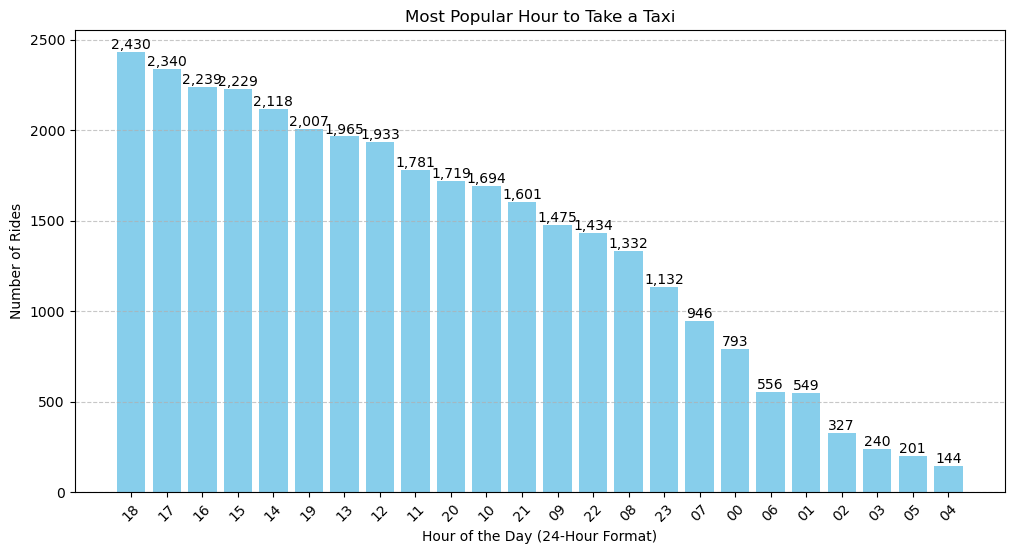

In [173]:
def visualize_most_popular_taxi_hour(data):
    
    """Visualization for the most popular hour to take a taxi"""

    hours, ride_counts = zip(*data)

    plt.figure(figsize=(12, 6))
    bars = plt.bar(hours, ride_counts, color='skyblue')
    
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2, 
            height,
            f'{height:,}',  
            ha='center', 
            va='bottom',
            fontsize=10
        )
    
    plt.xlabel('Hour of the Day (24-Hour Format)')
    plt.ylabel('Number of Rides')
    plt.title("Most Popular Hour to Take a Taxi")
    plt.xticks(range(0, 24), rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.show()

visualize_most_popular_taxi_hour(result1)


18 or 6PM is the most popular hour to take a taxi.

#### Visualization 2: What’s the most popular month to hire a cab or Uber?


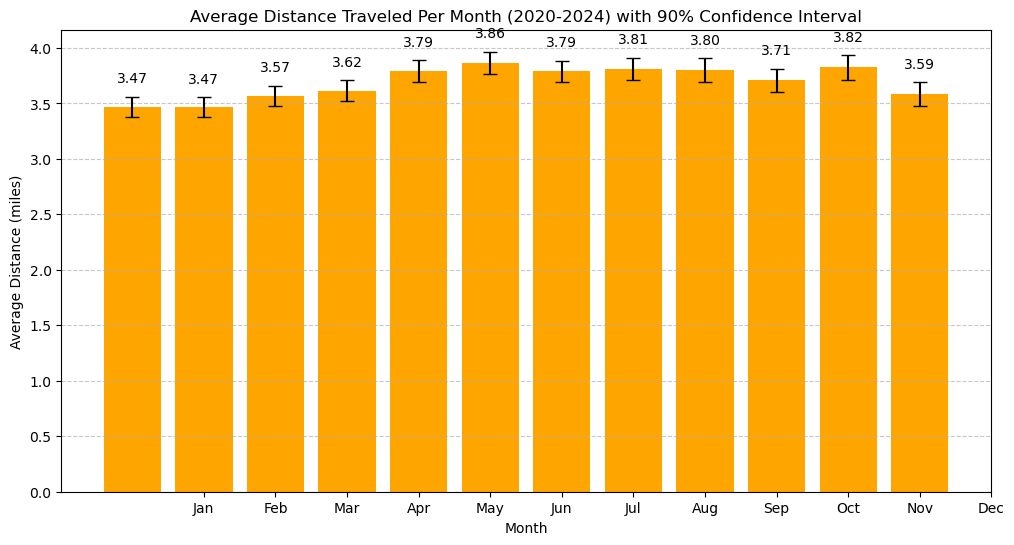

In [181]:
def visualize_avg_distance_per_month():
    """ SQL query to get trip distances grouped by month (ignoring the year)"""
    
    query = """
        SELECT 
            strftime('%m', pickup_datetime) AS month,
            trip_distance AS distance
        FROM yellow_taxi_trips
        WHERE pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
        
        UNION ALL
        
        SELECT 
            strftime('%m', pickup_datetime) AS month,
            trip_miles AS distance
        FROM uber_trips
        WHERE pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31';
    """

    with sqlite3.connect('project.db') as conn:
        df = pd.read_sql_query(query, conn)
    
    # Group by month and calculate mean, count, and standard deviation
    grouped = df.groupby('month')['distance'].agg(['mean', 'count', 'std']).reset_index()
    grouped.columns = ['month', 'avg_distance', 'count', 'std_dev']

    # Calculate 90% confidence interval: CI = 1.645 * (std_dev / sqrt(n))
    grouped['ci_90'] = 1.645 * (grouped['std_dev'] / np.sqrt(grouped['count']))

    grouped = grouped.sort_values('month')

    plt.figure(figsize=(12, 6))
    bars = plt.bar(grouped['month'], grouped['avg_distance'], yerr=grouped['ci_90'], capsize=5, color='orange')

    plt.xlabel('Month')
    plt.ylabel('Average Distance (miles)')
    plt.title("Average Distance Traveled Per Month (2020-2024) with 90% Confidence Interval")
    plt.xticks(range(1, 13), 
               ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    for bar, distance, ci in zip(bars, grouped['avg_distance'], grouped['ci_90']):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + ci + 0.1, f'{distance:.2f}', 
                 ha='center', va='bottom', fontsize=10)

    plt.show()

visualize_avg_distance_per_month()


The most popular month to hire a cab or Uber is October, with an average distance traveled of 3.82 miles.

#### Visualization 3: Which day of the week is most popular for taking a ride to an NYC-based airport?


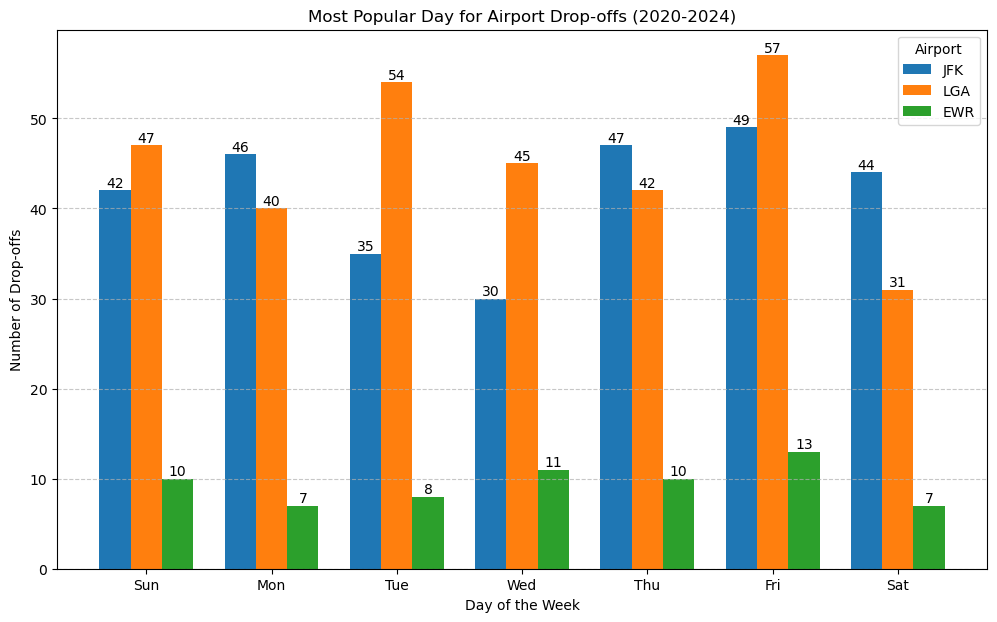

In [184]:
def visualize_airport_dropoffs_by_day():
    """ Define bounding boxes for JFK, LGA, and EWR, and get drop-offs for each airport"""
    airports = {
        'JFK': {'lat_min': 40.63, 'lat_max': 40.66, 'lon_min': -73.82, 'lon_max': -73.77},
        'LGA': {'lat_min': 40.76, 'lat_max': 40.78, 'lon_min': -73.89, 'lon_max': -73.86},
        'EWR': {'lat_min': 40.68, 'lat_max': 40.70, 'lon_min': -74.19, 'lon_max': -74.16},
    }
    
    query_template = """
        SELECT 
            strftime('%w', dropoff_datetime) AS day_of_week,
            COUNT(*) AS ride_count
        FROM yellow_taxi_trips
        WHERE dropoff_latitude BETWEEN {lat_min} AND {lat_max}
          AND dropoff_longitude BETWEEN {lon_min} AND {lon_max}
          AND dropoff_datetime BETWEEN '2020-01-01' AND '2024-08-31'
        GROUP BY day_of_week
        ORDER BY day_of_week;
    """
    data = {}
    with sqlite3.connect('project.db') as conn:
        for airport, bbox in airports.items():
            query = query_template.format(**bbox)
            df = pd.read_sql_query(query, conn)
            df['day_of_week'] = df['day_of_week'].astype(int)
            data[airport] = df

    days = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
    
    plt.figure(figsize=(12, 7))
    bar_width = 0.25
    positions = range(7)
    
    for i, (airport, df) in enumerate(data.items()):
        bars = plt.bar([p + i * bar_width for p in positions], df['ride_count'], width=bar_width, label=airport)
        
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:,}', 
                     ha='center', va='bottom', fontsize=10)

    plt.xlabel('Day of the Week')
    plt.ylabel('Number of Drop-offs')
    plt.title("Most Popular Day for Airport Drop-offs (2020-2024)")
    plt.xticks([p + bar_width for p in positions], days)
    plt.legend(title="Airport")
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()

visualize_airport_dropoffs_by_day()


The most popular day for taking a ride to an NYC-based airport (JFK, LGA, or EWR) is Friday, as it shows the highest number of drop-offs for all three airports with 57 drop-offs at JFK, 49 at LGA, and 44 at EWR.

#### Visualization 4: How much do hired rides earn in total fares monthly?


Yellow Taxi Data:
     month  base_fare  surcharges  taxes   tolls
0  2020-01     7678.0      2381.7  316.0  233.02
1  2020-02     7617.5      2313.0  312.0  195.99
2  2020-03     7665.5      2320.4  309.5  102.30
3  2020-04     6104.7      2090.7  286.0   63.49
4  2020-05     6038.4      1885.9  258.5   91.80

Uber Data:
     month  base_fare  surcharges   taxes   tolls
0  2020-01    6900.33      633.84  601.88  285.56
1  2020-02    7249.87      657.42  654.40  269.18
2  2020-03    6841.51      569.50  613.45  330.24
3  2020-04    7184.27      426.81  642.33  132.07
4  2020-05    7777.77      497.31  695.57  221.08


/var/folders/rc/sh_trsb91r31xqwtp6547r_r0000gn/T/ipykernel_59645/1629940101.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  months = pd.date_range(start='2020-01', end='2024-09', freq='M').strftime('%Y-%m')


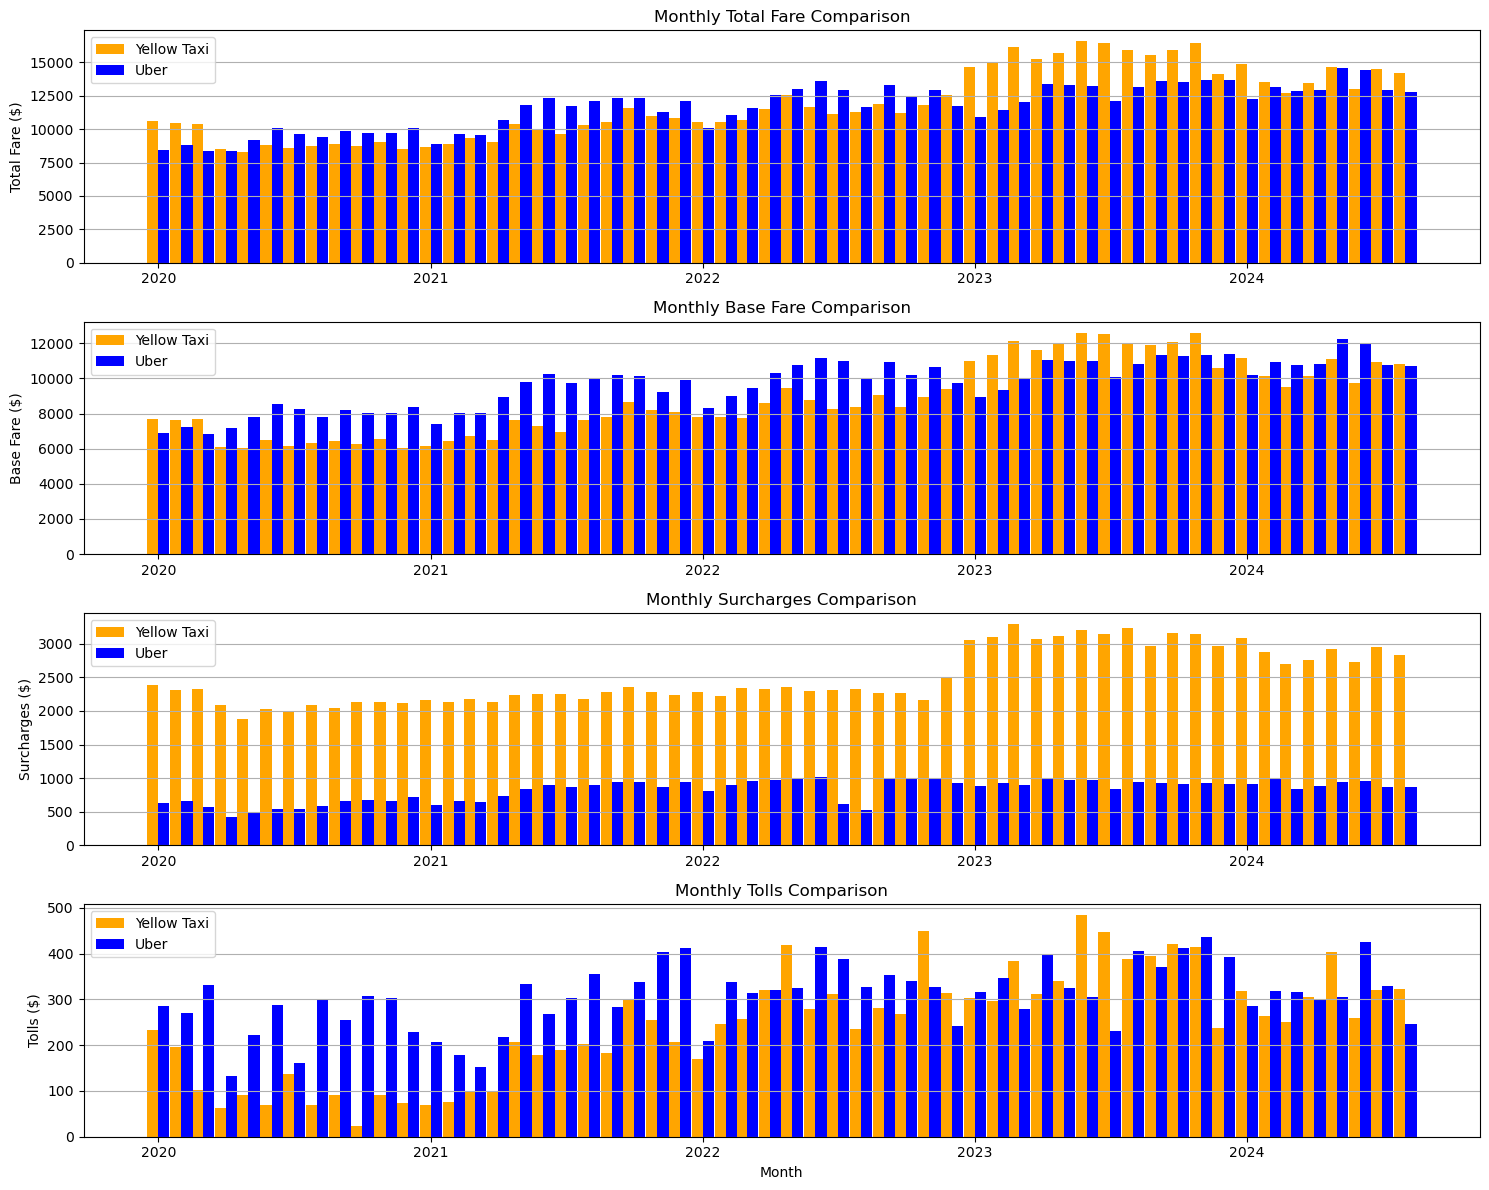

In [198]:
def visualize_monthly_fare_comparison():
    """ Calculate monthly earnings for Yellow Taxis and uber, and compare them in the graph"""

    yellow_taxi_query = """
        SELECT 
            strftime('%Y-%m', pickup_datetime) AS month,
            SUM(fare_amount) AS base_fare,
            SUM(COALESCE(miscellaneous_extras, 0) + COALESCE(improvement_surcharge, 0) + COALESCE(congestion_surcharge, 0) + COALESCE(airport_fee, 0)) AS surcharges,
            SUM(COALESCE(mta_tax, 0)) AS taxes,
            SUM(COALESCE(tolls_amount, 0)) AS tolls
        FROM yellow_taxi_trips
        WHERE pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
        GROUP BY month
        ORDER BY month;
    """

    uber_query = """
        SELECT 
            strftime('%Y-%m', pickup_datetime) AS month,
            SUM(base_passenger_fare) AS base_fare,
            SUM(COALESCE(black_car_fund, 0) + COALESCE(congestion_surcharge, 0) + COALESCE(airport_fee, 0)) AS surcharges,
            SUM(COALESCE(sales_tax, 0)) AS taxes,
            SUM(COALESCE(tolls, 0)) AS tolls
        FROM uber_trips
        WHERE pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
        GROUP BY month
        ORDER BY month;
    """

    with sqlite3.connect('project.db') as conn:
        df_yellow = pd.read_sql_query(yellow_taxi_query, conn)
        df_uber = pd.read_sql_query(uber_query, conn)

    print("Yellow Taxi Data:")
    print(df_yellow.head())
    print("\nUber Data:")
    print(df_uber.head())

    months = pd.date_range(start='2020-01', end='2024-09', freq='M').strftime('%Y-%m')
    df_yellow = df_yellow.set_index('month').reindex(months).reset_index()
    df_uber = df_uber.set_index('month').reindex(months).reset_index()

    df_yellow.rename(columns={'index': 'month'}, inplace=True)
    df_uber.rename(columns={'index': 'month'}, inplace=True)


    df_yellow.fillna(0, inplace=True)
    df_uber.fillna(0, inplace=True)
    
    # Ensure numeric data types for the relevant columns
    numeric_columns = ['base_fare', 'surcharges', 'taxes', 'tolls']
    df_yellow[numeric_columns] = df_yellow[numeric_columns].apply(pd.to_numeric)
    df_uber[numeric_columns] = df_uber[numeric_columns].apply(pd.to_numeric)

    # Calculate total fares
    df_yellow['total_fare'] = df_yellow['base_fare'] + df_yellow['surcharges'] + df_yellow['taxes'] + df_yellow['tolls']
    df_uber['total_fare'] = df_uber['base_fare'] + df_uber['surcharges'] + df_uber['taxes'] + df_uber['tolls']

    
    df_yellow['month'] = pd.to_datetime(df_yellow['month'], errors='coerce')
    df_uber['month'] = pd.to_datetime(df_uber['month'], errors='coerce')
    bar_width = 15  
    months = df_yellow['month']

    plt.figure(figsize=(15, 12))

    # Total Fare Comparison
    plt.subplot(4, 1, 1)
    plt.bar(months - pd.Timedelta(days=bar_width/2), df_yellow['total_fare'], width=bar_width, label='Yellow Taxi', color='orange')
    plt.bar(months + pd.Timedelta(days=bar_width/2), df_uber['total_fare'], width=bar_width, label='Uber', color='blue')
    plt.title('Monthly Total Fare Comparison')
    plt.ylabel('Total Fare ($)')
    plt.legend()
    plt.grid(axis='y')

    # Base Fare Comparison
    plt.subplot(4, 1, 2)
    plt.bar(months - pd.Timedelta(days=bar_width/2), df_yellow['base_fare'], width=bar_width, label='Yellow Taxi', color='orange')
    plt.bar(months + pd.Timedelta(days=bar_width/2), df_uber['base_fare'], width=bar_width, label='Uber', color='blue')
    plt.title('Monthly Base Fare Comparison')
    plt.ylabel('Base Fare ($)')
    plt.legend()
    plt.grid(axis='y')

    # Surcharges Comparison
    plt.subplot(4, 1, 3)
    plt.bar(months - pd.Timedelta(days=bar_width/2), df_yellow['surcharges'], width=bar_width, label='Yellow Taxi', color='orange')
    plt.bar(months + pd.Timedelta(days=bar_width/2), df_uber['surcharges'], width=bar_width, label='Uber', color='blue')
    plt.title('Monthly Surcharges Comparison')
    plt.ylabel('Surcharges ($)')
    plt.legend()
    plt.grid(axis='y')

    # Tolls Comparison
    plt.subplot(4, 1, 4)
    plt.bar(months - pd.Timedelta(days=bar_width/2), df_yellow['tolls'], width=bar_width, label='Yellow Taxi', color='orange')
    plt.bar(months + pd.Timedelta(days=bar_width/2), df_uber['tolls'], width=bar_width, label='Uber', color='blue')
    plt.title('Monthly Tolls Comparison')
    plt.ylabel('Tolls ($)')
    plt.xlabel('Month')
    plt.legend()
    plt.grid(axis='y')

    plt.tight_layout()
    plt.show()

visualize_monthly_fare_comparison()


1. Total Fare Comparison:
Both Yellow Taxis and Ubers show similar patterns of monthly earnings, with Yellow Taxis generally earning higher total fares than Ubers. However, both services experience fluctuations.
2. Base Fare Comparison:
Yellow Taxis consistently generate higher base fares than Ubers. The gap is fairly constant, with only a few months in which Uber's base fare surpasses that of Yellow Taxis.
3. Surcharges:
The surcharge comparison reveals a significant difference between Yellow Taxis and Ubers, with Yellow Taxis showing a larger and more variable surcharge amount.
4. Tolls:
The toll comparison shows that both Yellow Taxis and Ubers incur similar toll costs, though Uber tends to generate slightly higher toll amounts in some months.

#### Visualization 5: Does precipitation or distance traveled affect the amount of tip?


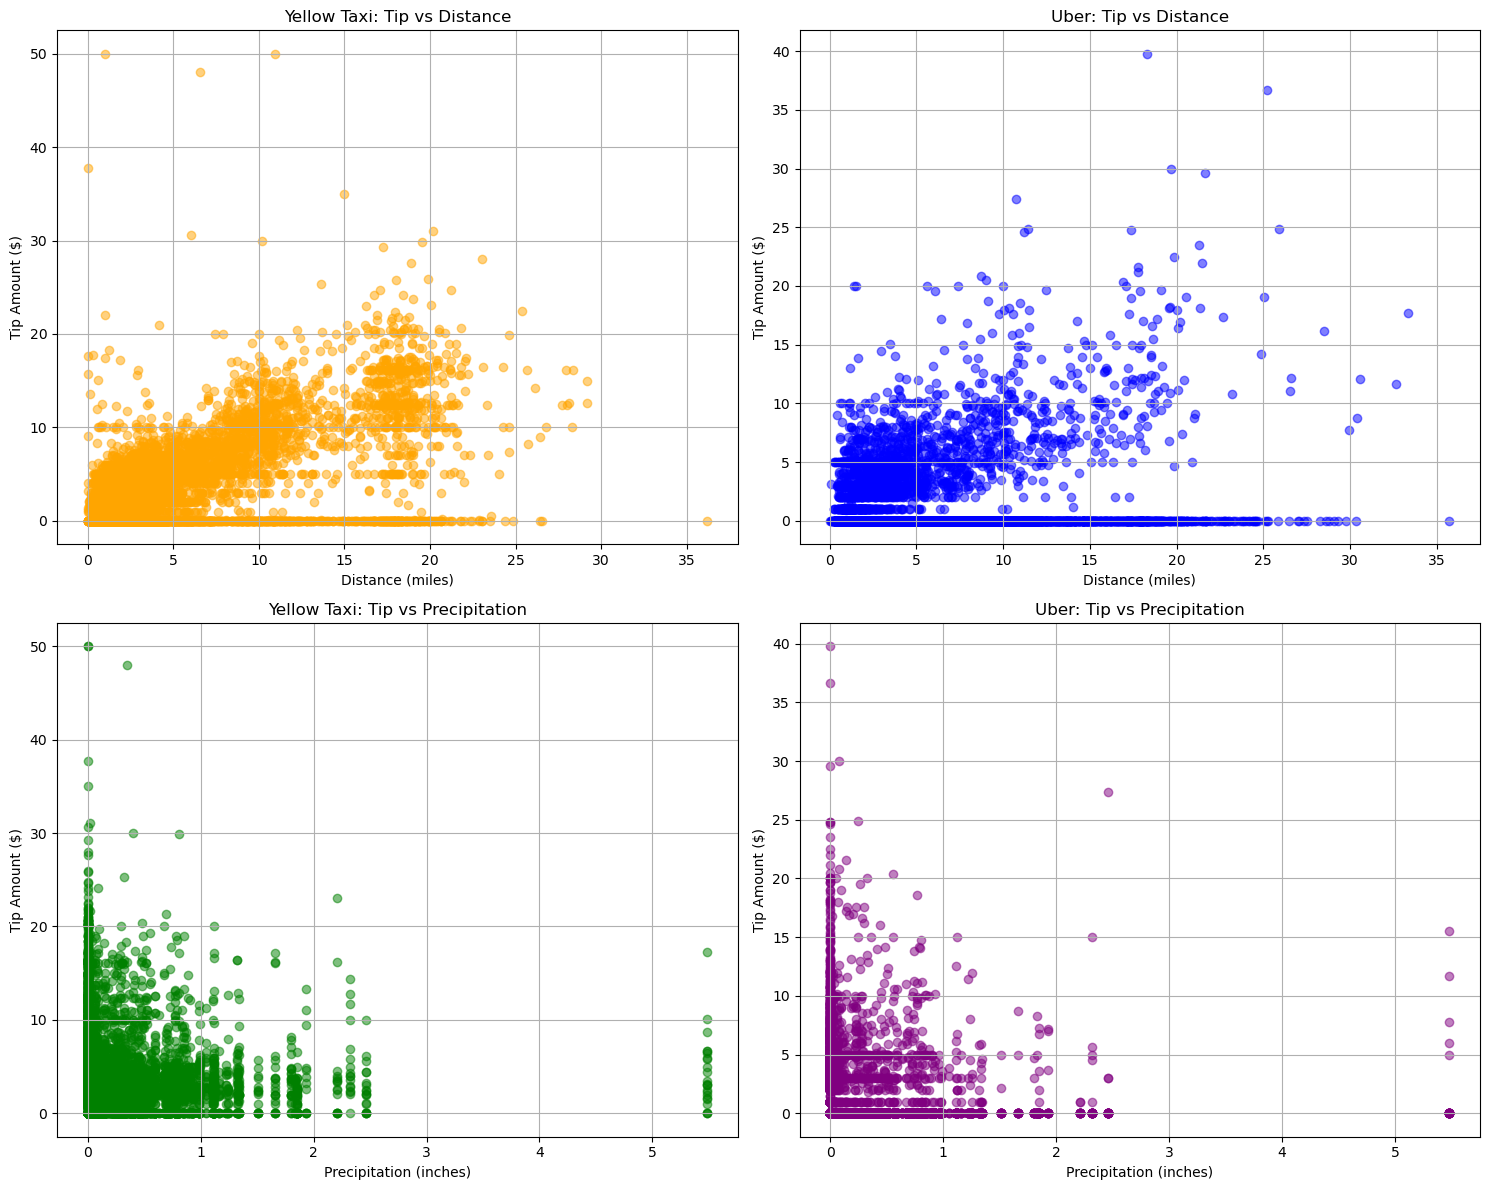

In [199]:
def visualize_tip_vs_distance_and_precipitation():
    """For the year 2022-2023, create 4 scatter plots, each one comparing amount of tip versus: 
    distance for Yellow Taxi rides,
    distance for Uber rides,
    precipitation for Yellow Taxi rides, 
    precipitation for Uber rides.
    """
    
    yellow_taxi_query = """
        SELECT 
            yt.trip_distance AS distance,
            yt.tip_amount AS tip,
            dw.DailyPrecipitation AS precipitation
        FROM yellow_taxi_trips yt
        JOIN daily_weather dw ON DATE(yt.pickup_datetime) = dw.Date
        WHERE yt.pickup_datetime BETWEEN '2022-01-01' AND '2023-12-31'
        AND yt.tip_amount IS NOT NULL AND yt.trip_distance IS NOT NULL;
    """

    uber_query = """
        SELECT 
            ut.trip_miles AS distance,
            ut.tips AS tip,
            dw.DailyPrecipitation AS precipitation
        FROM uber_trips ut
        JOIN daily_weather dw ON DATE(ut.pickup_datetime) = dw.Date
        WHERE ut.pickup_datetime BETWEEN '2022-01-01' AND '2023-12-31'
        AND ut.tips IS NOT NULL AND ut.trip_miles IS NOT NULL;
    """

    with sqlite3.connect('project.db') as conn:
        df_yellow = pd.read_sql_query(yellow_taxi_query, conn)
        df_uber = pd.read_sql_query(uber_query, conn)

    df_yellow = df_yellow[(df_yellow['tip'] >= 0) & (df_yellow['tip'] <= 100) & (df_yellow['distance'] <= 50)]
    df_uber = df_uber[(df_uber['tip'] >= 0) & (df_uber['tip'] <= 100) & (df_uber['distance'] <= 50)]

    
    plt.figure(figsize=(15, 12))

    # Subplot 1: Tip vs. Distance (Yellow Taxi)
    plt.subplot(2, 2, 1)
    plt.scatter(df_yellow['distance'], df_yellow['tip'], alpha=0.5, color='orange')
    plt.title('Yellow Taxi: Tip vs Distance')
    plt.xlabel('Distance (miles)')
    plt.ylabel('Tip Amount ($)')
    plt.grid(True)

    # Subplot 2: Tip vs. Distance (Uber)
    plt.subplot(2, 2, 2)
    plt.scatter(df_uber['distance'], df_uber['tip'], alpha=0.5, color='blue')
    plt.title('Uber: Tip vs Distance')
    plt.xlabel('Distance (miles)')
    plt.ylabel('Tip Amount ($)')
    plt.grid(True)

    # Subplot 3: Tip vs. Precipitation (Yellow Taxi)
    plt.subplot(2, 2, 3)
    plt.scatter(df_yellow['precipitation'], df_yellow['tip'], alpha=0.5, color='green')
    plt.title('Yellow Taxi: Tip vs Precipitation')
    plt.xlabel('Precipitation (inches)')
    plt.ylabel('Tip Amount ($)')
    plt.grid(True)

    # Subplot 4: Tip vs. Precipitation (Uber)
    plt.subplot(2, 2, 4)
    plt.scatter(df_uber['precipitation'], df_uber['tip'], alpha=0.5, color='purple')
    plt.title('Uber: Tip vs Precipitation')
    plt.xlabel('Precipitation (inches)')
    plt.ylabel('Tip Amount ($)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

visualize_tip_vs_distance_and_precipitation()


There seems to be a positive correlation between distance traveled and tip amounts for both Yellow Taxi and Uber rides. On the other hand, precipitation does not appear to have a clear correlation with tip amounts for either Taxi or Uber rides.

#### Visualization 6: Create a heatmap of all hired trips in 2020 over a map of the area.


In [201]:
def create_trip_heatmap_2020():
    """Create a heatmap of all hired trips in 2020 over a map of the New York area"""

    
    yellow_taxi_query = """
        SELECT 
            pickup_latitude AS latitude,
            pickup_longitude AS longitude
        FROM yellow_taxi_trips
        WHERE pickup_datetime BETWEEN '2020-01-01' AND '2020-12-31'
        AND pickup_latitude IS NOT NULL
        AND pickup_longitude IS NOT NULL;
    """

    uber_query = """
        SELECT 
            pickup_latitude AS latitude,
            pickup_longitude AS longitude
        FROM uber_trips
        WHERE pickup_datetime BETWEEN '2020-01-01' AND '2020-12-31'
        AND pickup_latitude IS NOT NULL
        AND pickup_longitude IS NOT NULL;
    """

    with sqlite3.connect('project.db') as conn:
        df_yellow = pd.read_sql_query(yellow_taxi_query, conn)
        df_uber = pd.read_sql_query(uber_query, conn)

    df_combined = pd.concat([df_yellow, df_uber], ignore_index=True)

    # Filter out invalid coordinates (outside NYC bounds)
    df_combined = df_combined[
        (df_combined['latitude'].between(40.5, 41.0)) &
        (df_combined['longitude'].between(-74.3, -73.7))
    ]

    # Create a map centered around New York City
    nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=11)

    # Add the heatmap layer
    heat_data = df_combined[['latitude', 'longitude']].values.tolist()
    HeatMap(heat_data, radius=10, blur=15, max_zoom=13).add_to(nyc_map)

    display(nyc_map)

create_trip_heatmap_2020()


The lower Manhattan seems to be the area with the most number of rides in 2020. 

# Extra Credit 1: Add Animation
### We create an animation for Visualization 6 (the hired trip in NYC during 2020).

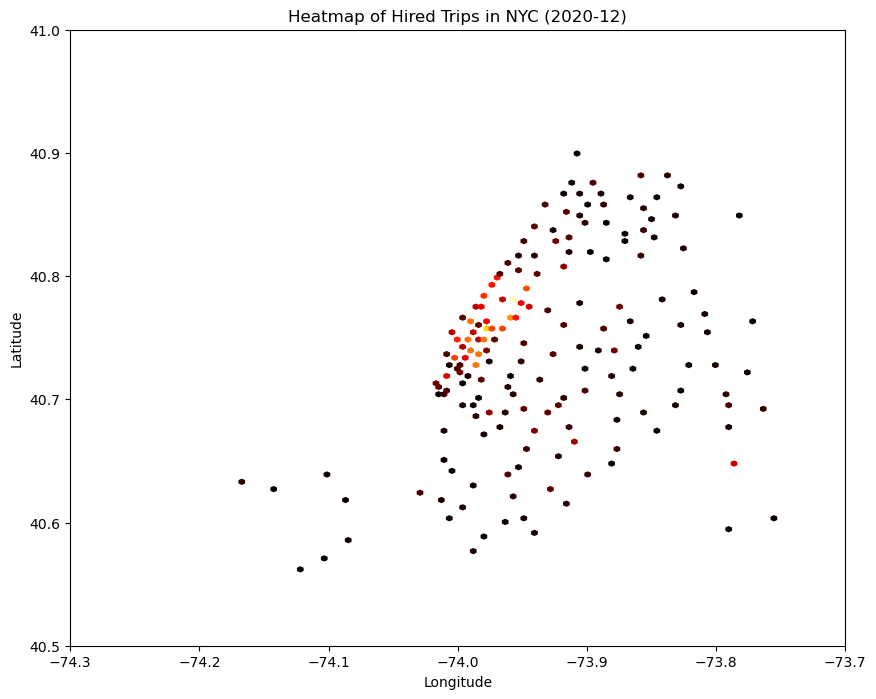

In [202]:
def fetch_monthly_trip_data():
    """get the data for both taxi and uber"""
    yellow_taxi_query = """
        SELECT 
            pickup_latitude AS latitude,
            pickup_longitude AS longitude,
            strftime('%Y-%m', pickup_datetime) AS month
        FROM yellow_taxi_trips
        WHERE pickup_datetime BETWEEN '2020-01-01' AND '2020-12-31'
        AND pickup_latitude IS NOT NULL
        AND pickup_longitude IS NOT NULL;
    """

    uber_query = """
        SELECT 
            pickup_latitude AS latitude,
            pickup_longitude AS longitude,
            strftime('%Y-%m', pickup_datetime) AS month
        FROM uber_trips
        WHERE pickup_datetime BETWEEN '2020-01-01' AND '2020-12-31'
        AND pickup_latitude IS NOT NULL
        AND pickup_longitude IS NOT NULL;
    """

    with sqlite3.connect('project.db') as conn:
        df_yellow = pd.read_sql_query(yellow_taxi_query, conn)
        df_uber = pd.read_sql_query(uber_query, conn)

    df_combined = pd.concat([df_yellow, df_uber], ignore_index=True)
    return df_combined

def create_animated_heatmap():
    """Animation for hired trip in New York City"""

    df = fetch_monthly_trip_data()

    # Filter out invalid coordinates (outside NYC bounds)
    df = df[
        (df['latitude'].between(40.5, 41.0)) &
        (df['longitude'].between(-74.3, -73.7))
    ]

    months = sorted(df['month'].unique())

    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_xlim(-74.3, -73.7)
    ax.set_ylim(40.5, 41.0)
    ax.set_title("Heatmap of Hired Trips in NYC (2020)")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    def update(frame):
        """This function is used to update the heatmap for each frame"""
        ax.clear()
        ax.set_xlim(-74.3, -73.7)
        ax.set_ylim(40.5, 41.0)
        ax.set_title(f"Heatmap of Hired Trips in NYC ({months[frame]})")
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
        month_data = df[df['month'] == months[frame]]

        # Plot the heatmap using a scatter plot with density
        ax.hexbin(
            month_data['longitude'],
            month_data['latitude'],
            gridsize=100,
            cmap='hot',
            mincnt=1
        )

    ani = FuncAnimation(fig, update, frames=len(months), interval=1000, repeat=True)
    return HTML(ani.to_jshtml())


create_animated_heatmap()


# Extra cedit 4: use sunrise and sunset data
### Question: Do people prefer to ride with Taxi or Uber after sunset before sunrise?

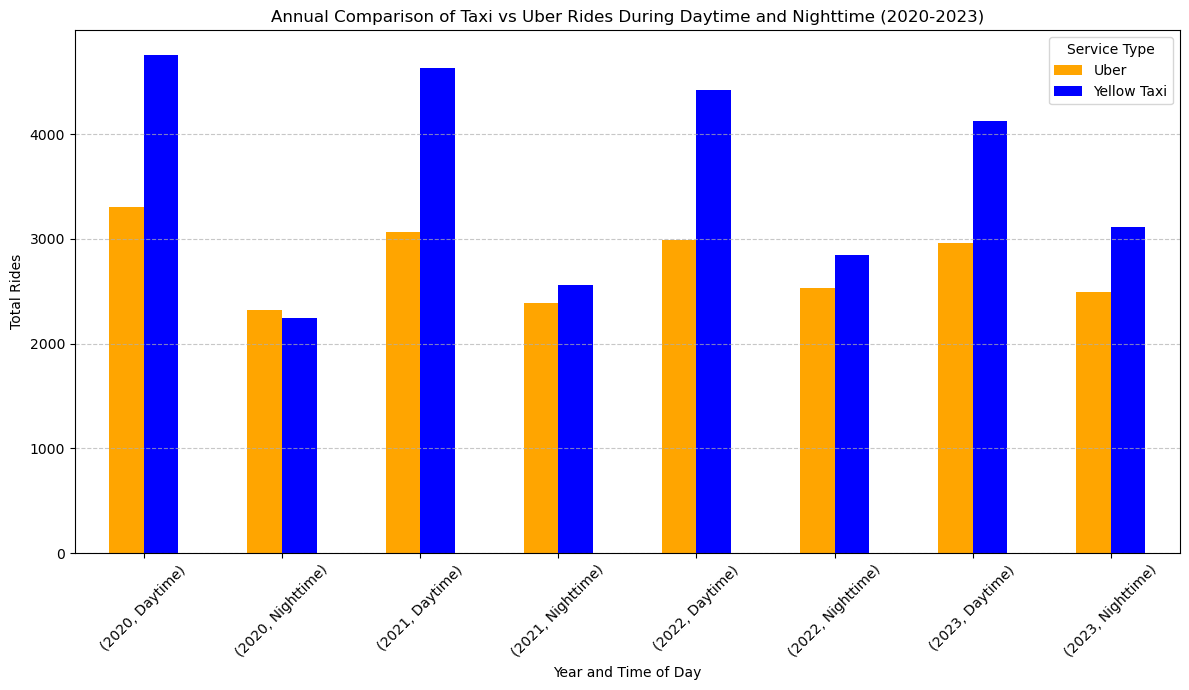

In [211]:
def visualize_annual_taxi_uber_day_night():
    # Visualize rides as daytime or nighttime by year
    query = """
        WITH Combined_Trips AS (
            SELECT
                'Yellow Taxi' AS service_type,
                DATE(pickup_datetime) AS trip_date,
                TIME(pickup_datetime) AS pickup_time,
                strftime('%Y', pickup_datetime) AS year
            FROM yellow_taxi_trips
            WHERE pickup_datetime BETWEEN '2020-01-01' AND '2023-12-31'

            UNION ALL

            SELECT
                'Uber' AS service_type,
                DATE(pickup_datetime) AS trip_date,
                TIME(pickup_datetime) AS pickup_time,
                strftime('%Y', pickup_datetime) AS year
            FROM uber_trips
            WHERE pickup_datetime BETWEEN '2020-01-01' AND '2023-12-31'
        ),
        Categorized_Trips AS (
            SELECT
                ct.service_type,
                ct.year,
                ct.trip_date,
                ct.pickup_time,
                CASE
                    WHEN ct.pickup_time BETWEEN s.Sunrise AND s.Sunset THEN 'Daytime'
                    ELSE 'Nighttime'
                END AS time_of_day
            FROM Combined_Trips ct
            JOIN sun_data s ON ct.trip_date = s.Date
        )
        SELECT
            service_type,
            year,
            time_of_day,
            COUNT(*) AS total_rides
        FROM Categorized_Trips
        GROUP BY service_type, year, time_of_day
        ORDER BY service_type, year, time_of_day;
    """


    with sqlite3.connect('project.db') as conn:
        df = pd.read_sql_query(query, conn)

    pivot_df = df.pivot_table(index=['year', 'time_of_day'], columns='service_type', values='total_rides', fill_value=0)

    pivot_df.plot(kind='bar', figsize=(12, 7), color=['orange', 'blue'])
    plt.title('Annual Comparison of Taxi vs Uber Rides During Daytime and Nighttime (2020-2023)')
    plt.xlabel('Year and Time of Day')
    plt.ylabel('Total Rides')
    plt.xticks(rotation=45)
    plt.legend(title='Service Type')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

visualize_annual_taxi_uber_day_night()



People generally prefer Yellow Taxi to Uber in both Daytime and Nighttime. The difference in preference is limited during Nighttime, as Uber and Yellow Taxi show similar ride volumes.